# 2D UNet Batch Medical Image Segmentation

## 1. Environment Setup and Configuration

In [2]:
# Import necessary libraries for batch processing
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from pynq_dpu import DpuOverlay
import json

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
%matplotlib inline

print(" Libraries imported successfully")
print(f" Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Libraries imported successfully
 Current time: 2025-11-01 10:59:01


In [3]:
# ==================== 配置参数 ====================
INPUT_DIR = "/root/jupyter_notebooks/pynq-dputest/cell/cell_images"
OUTPUT_DIR = "/root/jupyter_notebooks/pynq-dputest/cell/batch_results"
MODEL_PATH = "/root/jupyter_notebooks/pynq-dputest/cell/medical_seg_cell_tf2_acc.xmodel"
BITSTREAM_PATH = "/root/jupyter_notebooks/pynq-dpu/dpu.bit"

# 分割阈值
SEGMENTATION_THRESHOLD = 0.5

# 可视化设置
MAX_VISUALIZATIONS = 50  # 最大可视化结果数量

print(" Configuration Parameters:")
print(f"   Input Directory: {INPUT_DIR}")
print(f"   Output Directory: {OUTPUT_DIR}")
print(f"   Model Path: {MODEL_PATH}")
print(f"   Bitstream Path: {BITSTREAM_PATH}")
print(f"   Segmentation Threshold: {SEGMENTATION_THRESHOLD}")
print(f"   Max Visualizations: {MAX_VISUALIZATIONS}")

 Configuration Parameters:
   Input Directory: /root/jupyter_notebooks/pynq-dputest/cell/cell_images
   Output Directory: /root/jupyter_notebooks/pynq-dputest/cell/batch_results
   Model Path: /root/jupyter_notebooks/pynq-dputest/cell/medical_seg_cell_tf2_acc.xmodel
   Bitstream Path: /root/jupyter_notebooks/pynq-dpu/dpu.bit
   Segmentation Threshold: 0.5
   Max Visualizations: 50


## 2. Performance Monitoring System

A comprehensive performance monitoring class to track processing times, throughput, and generate detailed reports.

In [4]:
class PerformanceMonitor:
    """Performance monitoring class for tracking batch processing statistics"""

    def __init__(self):
        self.inference_times = []
        self.preprocessing_times = []
        self.postprocessing_times = []
        self.total_times = []
        self.file_names = []
        self.segmentation_stats = []
        self.start_time = None
        self.end_time = None

    def start_session(self):
        """Start processing session"""
        self.start_time = time.time()
        print(f" Processing session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    def end_session(self):
        """End processing session"""
        self.end_time = time.time()
        total_elapsed = self.end_time - self.start_time
        print(f" Processing session ended: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f" Total session time: {total_elapsed:.2f} seconds")

    def add_record(self, file_name, preprocess_time, inference_time,
                   postprocess_time, total_time, seg_pixels, coverage):
        """Add single processing record"""
        self.file_names.append(file_name)
        self.preprocessing_times.append(preprocess_time)
        self.inference_times.append(inference_time)
        self.postprocessing_times.append(postprocess_time)
        self.total_times.append(total_time)
        self.segmentation_stats.append({
            'segmented_pixels': seg_pixels,
            'coverage_percent': coverage
        })

    def get_statistics(self):
        """Get performance statistics"""
        if not self.inference_times:
            return None

        total_elapsed = (self.end_time - self.start_time) if self.end_time else 0

        return {
            'total_images': len(self.file_names),
            'total_elapsed_time': total_elapsed,
            'avg_inference_time': float(np.mean(self.inference_times)),
            'min_inference_time': float(np.min(self.inference_times)),
            'max_inference_time': float(np.max(self.inference_times)),
            'std_inference_time': float(np.std(self.inference_times)),
            'avg_preprocessing_time': float(np.mean(self.preprocessing_times)),
            'avg_postprocessing_time': float(np.mean(self.postprocessing_times)),
            'avg_total_time': float(np.mean(self.total_times)),
            'throughput_fps': float(len(self.inference_times) / total_elapsed if total_elapsed > 0 else 0),
            'avg_segmented_pixels': float(np.mean([s['segmented_pixels'] for s in self.segmentation_stats])),
            'avg_coverage_percent': float(np.mean([s['coverage_percent'] for s in self.segmentation_stats]))
        }

    def print_detailed_report(self):
        """Print detailed performance report"""
        stats = self.get_statistics()

        if not stats:
            print("❌ No performance data available")
            return

        print("\n" + "="*80)
        print(" "*25 + " 2D UNet Batch Processing Performance Report")
        print("="*80)

        # Basic statistics
        print(f"\n Processing Overview:")
        print(f"  ├─ Total images processed: {stats['total_images']}")
        print(f"  ├─ Total session time: {stats['total_elapsed_time']:.2f} seconds")
        print(f"  ├─ Average throughput: {stats['throughput_fps']:.2f} FPS")
        print(f"  └─ Processing speed: {stats['total_images']/stats['total_elapsed_time']*60:.1f} images/minute")

        # Inference performance
        print(f"\n Inference Performance (milliseconds):")
        print(f"  ├─ Average inference time: {stats['avg_inference_time']*1000:.2f} ms")
        print(f"  ├─ Minimum inference time: {stats['min_inference_time']*1000:.2f} ms")
        print(f"  ├─ Maximum inference time: {stats['max_inference_time']*1000:.2f} ms")
        print(f"  └─ Standard deviation: {stats['std_inference_time']*1000:.2f} ms")

        # Processing stage analysis
        print(f"\n Processing Stage Time Analysis:")
        print(f"  ├─ Preprocessing: {stats['avg_preprocessing_time']*1000:.2f} ms ({stats['avg_preprocessing_time']/stats['avg_total_time']*100:.1f}%)")
        print(f"  ├─ Inference: {stats['avg_inference_time']*1000:.2f} ms ({stats['avg_inference_time']/stats['avg_total_time']*100:.1f}%)")
        print(f"  ├─ Postprocessing: {stats['avg_postprocessing_time']*1000:.2f} ms ({stats['avg_postprocessing_time']/stats['avg_total_time']*100:.1f}%)")
        print(f"  └─ Total: {stats['avg_total_time']*1000:.2f} ms")

        # Segmentation statistics
        print(f"\n Segmentation Quality Statistics:")
        print(f"  ├─ Average segmented pixels: {stats['avg_segmented_pixels']:.0f}")
        print(f"  ├─ Average coverage: {stats['avg_coverage_percent']:.2f}%")
        print(f"  ├─ Highest coverage: {max([s['coverage_percent'] for s in self.segmentation_stats]):.2f}%")
        print(f"  └─ Lowest coverage: {min([s['coverage_percent'] for s in self.segmentation_stats]):.2f}%")

        # Performance stability analysis
        cv_inference = stats['std_inference_time'] / stats['avg_inference_time'] * 100
        print(f"\n📈 Performance Stability:")
        print(f"  ├─ Inference time coefficient of variation: {cv_inference:.2f}%")
        if cv_inference < 5:
            print(f"  └─ Assessment: Excellent (very stable)")
        elif cv_inference < 10:
            print(f"  └─ Assessment: Good (relatively stable)")
        else:
            print(f"  └─ Assessment: Fair (high variability)")

        print("\n" + "="*80)

    def save_to_json(self, output_path):
        """Save detailed statistics to JSON file"""
        stats = self.get_statistics()

        # Convert all NumPy types to native Python types for JSON serialization
        def convert_numpy_types(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, dict):
                return {key: convert_numpy_types(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_types(item) for item in obj]
            else:
                return obj

        data = {
            'session_info': {
                'timestamp': datetime.now().isoformat(),
                'total_elapsed_time': float(stats['total_elapsed_time']) if stats else 0.0,
                'start_time': datetime.fromtimestamp(self.start_time).isoformat() if self.start_time else None,
                'end_time': datetime.fromtimestamp(self.end_time).isoformat() if self.end_time else None
            },
            'performance_summary': convert_numpy_types(stats) if stats else {},
            'detailed_records': []
        }

        for i in range(len(self.file_names)):
            record = {
                'file_name': str(self.file_names[i]),
                'preprocessing_time_ms': float(self.preprocessing_times[i]) * 1000,
                'inference_time_ms': float(self.inference_times[i]) * 1000,
                'postprocessing_time_ms': float(self.postprocessing_times[i]) * 1000,
                'total_time_ms': float(self.total_times[i]) * 1000,
                'segmented_pixels': int(self.segmentation_stats[i]['segmented_pixels']),
                'coverage_percent': float(self.segmentation_stats[i]['coverage_percent'])
            }
            data['detailed_records'].append(record)

        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)

        print(f" Performance report saved to: {output_path}")

# Test the performance monitor
print(" Performance monitoring system initialized")
test_monitor = PerformanceMonitor()
print(f" PerformanceMonitor class created successfully")

 Performance monitoring system initialized
 PerformanceMonitor class created successfully


## 3. Image Processing Functions

Core functions for preprocessing medical images and post-processing segmentation outputs.

In [5]:
def preprocess_medical_image(image, target_shape):
    """
    Preprocess medical image to match model input requirements.
    
    Args:
        image: Input medical image (H, W, C)
        target_shape: Target shape (B, H, W, C)
    
    Returns:
        Preprocessed image with correct format
    """
    # Ensure image is in correct format (float32)
    processed_image = image.astype(np.float32)
    
    # Add batch dimension if needed
    if len(processed_image.shape) == 3:
        processed_image = np.expand_dims(processed_image, axis=0)
    
    return processed_image

def postprocess_segmentation(output, threshold=SEGMENTATION_THRESHOLD):
    """
    Post-process segmentation output to create binary mask.
    
    Args:
        output: Model output tensor
        threshold: Binary segmentation threshold
    
    Returns:
        binary_mask: Binary segmentation mask
        probability_map: Segmentation probability map
    """
    # Remove batch dimension if present
    if len(output.shape) == 4:
        output = output[0]
    
    # Apply sigmoid activation (if not already applied)
    if output.max() > 1.0:
        probability_map = 1 / (1 + np.exp(-output))
    else:
        probability_map = output
    
    # Create binary mask (threshold at specified value)
    binary_mask = (probability_map > threshold).astype(np.float32)
    
    return binary_mask, probability_map

print(" Image processing functions defined")
print(" preprocess_medical_image() - for model input preparation")
print(" postprocess_segmentation() - for output processing")

 Image processing functions defined
 preprocess_medical_image() - for model input preparation
 postprocess_segmentation() - for output processing


## 4. Visualization Functions

Functions for creating comprehensive visualizations of segmentation results.

In [6]:
def visualize_segmentation_result(original_image, probability_map, binary_mask,
                                file_name, save_dir=None):
    """
    Create comprehensive visualization of segmentation result.
    
    Args:
        original_image: Original RGB medical image
        probability_map: Segmentation probability map
        binary_mask: Binary segmentation mask
        file_name: Name of the processed file
        save_dir: Directory to save visualization
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'2D UNet Segmentation Result: {file_name}', fontsize=16, fontweight='bold')

    # Original RGB image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Medical Image (RGB)')
    axes[0, 0].axis('off')

    # Green channel (often good for cell visualization)
    axes[0, 1].imshow(original_image[:, :, 1], cmap='gray')
    axes[0, 1].set_title('Green Channel')
    axes[0, 1].axis('off')

    # Probability map
    prob_map_display = probability_map.squeeze() if len(probability_map.shape) > 2 else probability_map
    prob_display = axes[0, 2].imshow(prob_map_display, cmap='hot', vmin=0, vmax=1)
    axes[0, 2].set_title('Segmentation Probability Map')
    axes[0, 2].axis('off')
    plt.colorbar(prob_display, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Binary segmentation mask
    mask_display = binary_mask.squeeze() if len(binary_mask.shape) > 2 else binary_mask
    axes[1, 0].imshow(mask_display, cmap='gray')
    axes[1, 0].set_title('Binary Segmentation Mask')
    axes[1, 0].axis('off')

    # Overlay segmentation on original image
    overlay = np.zeros_like(original_image)
    overlay[:, :, 1] = mask_display * 0.7  # Green overlay
    combined = original_image * 0.7 + overlay
    combined = np.clip(combined, 0, 1)
    axes[1, 1].imshow(combined)
    axes[1, 1].set_title('Segmentation Overlay')
    axes[1, 1].axis('off')

    # Zoomed view of interesting region (if segmentation detected)
    if np.sum(mask_display) > 0:
        # Find a region with segmentation
        y_indices, x_indices = np.where(mask_display > 0)
        if len(y_indices) > 0:
            center_y, center_x = np.mean(y_indices), np.mean(x_indices)
            crop_size = 32
            y_start = max(0, int(center_y) - crop_size//2)
            y_end = min(original_image.shape[0], int(center_y) + crop_size//2)
            x_start = max(0, int(center_x) - crop_size//2)
            x_end = min(original_image.shape[1], int(center_x) + crop_size//2)

            axes[1, 2].imshow(original_image[y_start:y_end, x_start:x_end])
            axes[1, 2].imshow(mask_display[y_start:y_end, x_start:x_end],
                             cmap='Reds', alpha=0.5)
            axes[1, 2].set_title('Zoomed Region with Segmentation')
            axes[1, 2].axis('off')
    else:
        axes[1, 2].text(0.5, 0.5, 'No segmentation detected',
                        ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].axis('off')

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{os.path.splitext(file_name)[0]}_visualization.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f" Visualization saved: {save_path}")

    plt.show()

def plot_performance_charts(perf_monitor):
    """
    Generate comprehensive performance analysis charts.
    
    Args:
        perf_monitor: PerformanceMonitor instance with data
    """
    if not perf_monitor.inference_times:
        print("❌ No performance data available for plotting")
        return None

    stats = perf_monitor.get_statistics()
    
    # Create comprehensive figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('2D UNet Batch Processing Performance Analysis', fontsize=16, fontweight='bold')

    # 1. Inference time trend
    inference_times_ms = [t * 1000 for t in perf_monitor.inference_times]
    axes[0, 0].plot(inference_times_ms, marker='o', linestyle='-', color='blue', alpha=0.7)
    axes[0, 0].set_title('Inference Time Trend')
    axes[0, 0].set_xlabel('Image Index')
    axes[0, 0].set_ylabel('Inference Time (ms)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(np.mean(inference_times_ms), color='red', linestyle='--',
                       label=f'Average: {np.mean(inference_times_ms):.2f} ms')
    axes[0, 0].legend()

    # 2. Processing stage time comparison
    stages = ['Preprocessing', 'Inference', 'Postprocessing']
    avg_times = [
        np.mean(perf_monitor.preprocessing_times) * 1000,
        np.mean(perf_monitor.inference_times) * 1000,
        np.mean(perf_monitor.postprocessing_times) * 1000
    ]
    bars = axes[0, 1].bar(stages, avg_times, color=['lightgreen', 'lightblue', 'lightcoral'])
    axes[0, 1].set_title('Average Processing Time by Stage')
    axes[0, 1].set_ylabel('Time (ms)')
    
    # Add value labels on bars
    for bar, time_val in zip(bars, avg_times):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_times)*0.01,
                       f'{time_val:.2f}', ha='center', va='bottom', fontweight='bold')

    # 3. Inference time distribution histogram
    axes[1, 0].hist(inference_times_ms, bins=15, color='orange', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Inference Time Distribution')
    axes[1, 0].set_xlabel('Inference Time (ms)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(np.mean(inference_times_ms), color='red', linestyle='--',
                       label=f'Mean: {np.mean(inference_times_ms):.2f} ms')
    axes[1, 0].legend()

    # 4. Segmentation coverage distribution
    coverage_values = [s['coverage_percent'] for s in perf_monitor.segmentation_stats]
    axes[1, 1].bar(range(len(coverage_values)), coverage_values, color='purple', alpha=0.7)
    axes[1, 1].set_title('Segmentation Coverage by Image')
    axes[1, 1].set_xlabel('Image Index')
    axes[1, 1].set_ylabel('Coverage (%)')
    axes[1, 1].axhline(np.mean(coverage_values), color='red', linestyle='--',
                       label=f'Average: {np.mean(coverage_values):.2f}%')
    axes[1, 1].legend()

    plt.tight_layout()
    
    return fig

print(" Visualization functions defined")
print(" visualize_segmentation_result() - for individual image visualization")
print(" plot_performance_charts() - for performance analysis charts")

 Visualization functions defined
 visualize_segmentation_result() - for individual image visualization
 plot_performance_charts() - for performance analysis charts


## 5. Data Preview and Validation

Let's examine the input data and validate our setup before starting batch processing.

 Examining input data...
 Input directory: /root/jupyter_notebooks/pynq-dputest/cell/cell_images
 Found NPY files: 20

 Sample image analysis:
  ├─ File: TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500_preprocessed.npy
  ├─ Shape: (128, 128, 3)
  ├─ Data type: float32
  ├─ Value range: 0.2682 to 0.9417
  └─ Mean value: 0.6619

 Image format validation: PASSED


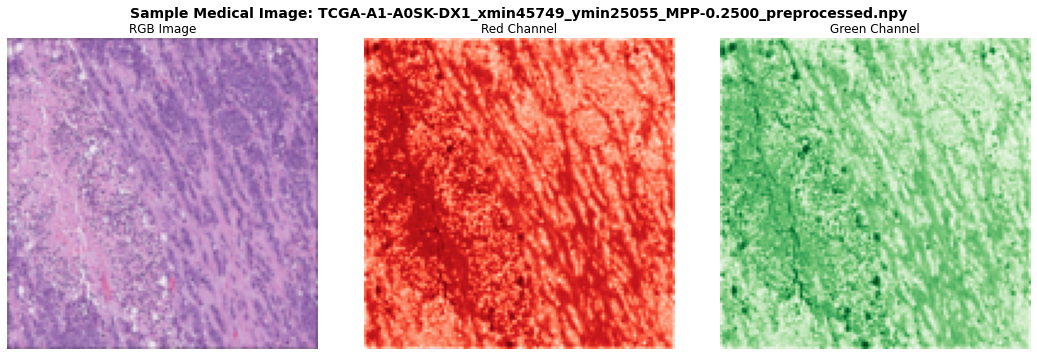

In [7]:
# Examine input data
print(" Examining input data...")

# Get all NPY files
npy_files = sorted(glob.glob(os.path.join(INPUT_DIR, "*.npy")))

print(f" Input directory: {INPUT_DIR}")
print(f" Found NPY files: {len(npy_files)}")

if len(npy_files) > 0:
    # Load and examine sample image
    sample_image = np.load(npy_files[0])
    print(f"\n Sample image analysis:")
    print(f"  ├─ File: {os.path.basename(npy_files[0])}")
    print(f"  ├─ Shape: {sample_image.shape}")
    print(f"  ├─ Data type: {sample_image.dtype}")
    print(f"  ├─ Value range: {sample_image.min():.4f} to {sample_image.max():.4f}")
    print(f"  └─ Mean value: {sample_image.mean():.4f}")
    
    # Validate image format
    expected_shape = (128, 128, 3)
    if sample_image.shape == expected_shape:
        print(f"\n Image format validation: PASSED")
    else:
        print(f"\n Image format warning: Expected {expected_shape}, got {sample_image.shape}")
        
    # Display sample image
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample Medical Image: {os.path.basename(npy_files[0])}', fontsize=14, fontweight='bold')
    
    # RGB image
    axes[0].imshow(sample_image)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    # Individual channels
    axes[1].imshow(sample_image[:, :, 0], cmap='Reds')
    axes[1].set_title('Red Channel')
    axes[1].axis('off')
    
    axes[2].imshow(sample_image[:, :, 1], cmap='Greens')
    axes[2].set_title('Green Channel')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(" No NPY files found in input directory!")

## 6. DPU Setup and Model Loading

Load the DPU overlay and the 2D UNet model for batch processing.

In [8]:
# Load DPU overlay
print(f" Loading DPU overlay: {BITSTREAM_PATH}")
try:
    overlay = DpuOverlay(BITSTREAM_PATH)
    print(" DPU overlay loaded successfully")
except Exception as e:
    print(f" Failed to load DPU overlay: {e}")
    raise

# Load the model
print(f" Loading model: {MODEL_PATH}")
try:
    overlay.load_model(MODEL_PATH)
    print(" Model loaded successfully")
except Exception as e:
    print(f" Failed to load model: {e}")
    del overlay
    raise

# Get DPU runner
dpu = overlay.runner

# Get input and output tensor information
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)

print(f"\n📐 Model Information:")
print(f"  ├─ Input shape: {shapeIn}")
print(f"  └─ Output shape: {shapeOut}")

# Prepare input and output buffers
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image_buffer = input_data[0]

print(f"\n Buffer Information:")
print(f"  ├─ Input buffer shape: {image_buffer.shape}")
print(f"  └─ Output buffer shape: {output_data[0].shape}")

 Loading DPU overlay: /root/jupyter_notebooks/pynq-dpu/dpu.bit


 DPU overlay loaded successfully
 Loading model: /root/jupyter_notebooks/pynq-dputest/cell/medical_seg_cell_tf2_acc.xmodel
 Model loaded successfully

📐 Model Information:
  ├─ Input shape: (1, 128, 128, 3)
  └─ Output shape: (1, 128, 128, 1)

 Buffer Information:
  ├─ Input buffer shape: (1, 128, 128, 3)
  └─ Output buffer shape: (1, 128, 128, 1)


## 7. Batch Processing Execution

Execute the main batch processing loop with progress tracking and performance monitoring.

 Starting batch processing execution...

 Found 20 image files for processing
 Input directory: /root/jupyter_notebooks/pynq-dputest/cell/cell_images
 Output directory: /root/jupyter_notebooks/pynq-dputest/cell/batch_results
 Processing session started: 2025-11-01 10:59:08

 Starting batch processing...


Processing Images:   0%|          | 0/20 [00:00<?, ?image/s]

 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500_preprocessed_visualization.png


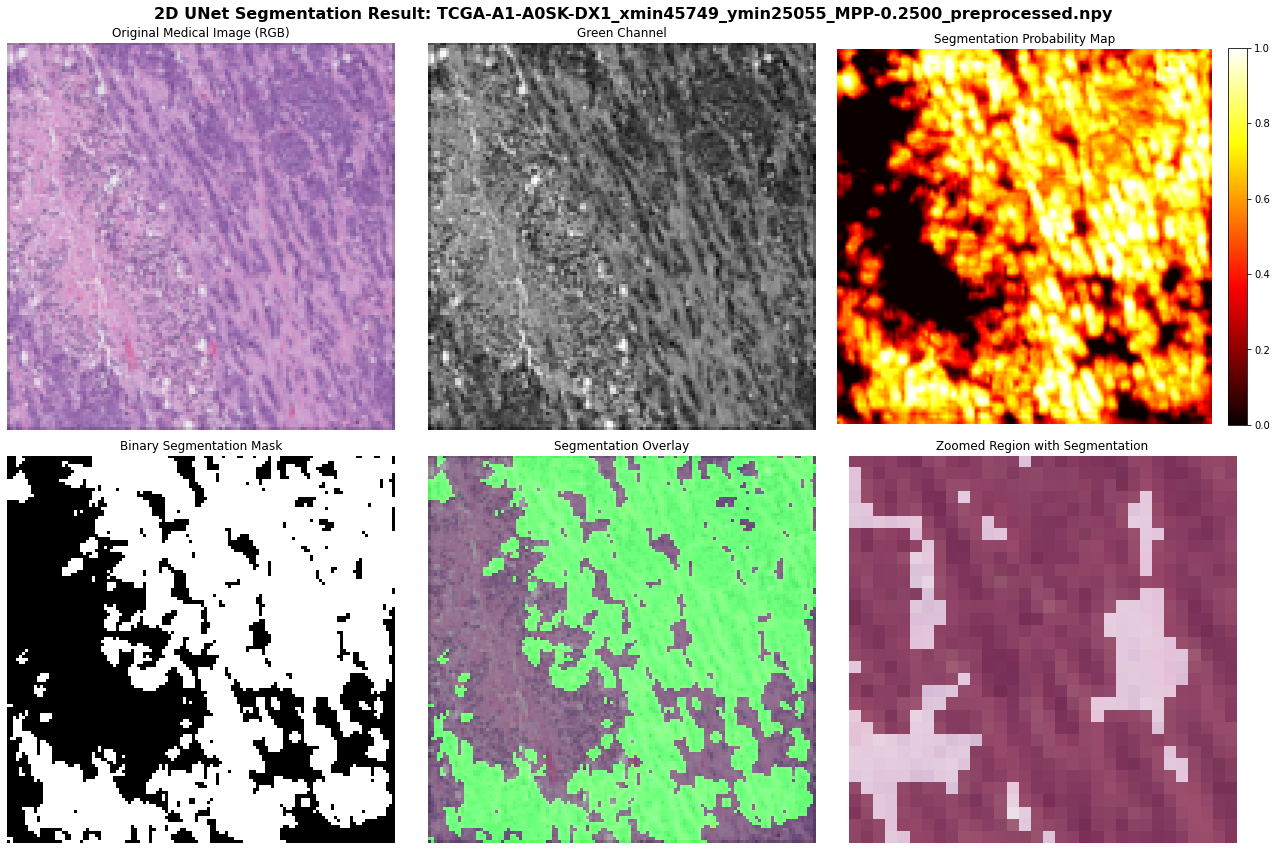

Processing Images:   5%|▌         | 1/20 [00:07<02:26,  7.69s/image]

 TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500_preprocessed.npy: Inference=6.9ms, Coverage=58.1%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A1-A0SP-DX1_xmin6798_ymin53719_MPP-0.2500_preprocessed_visualization.png


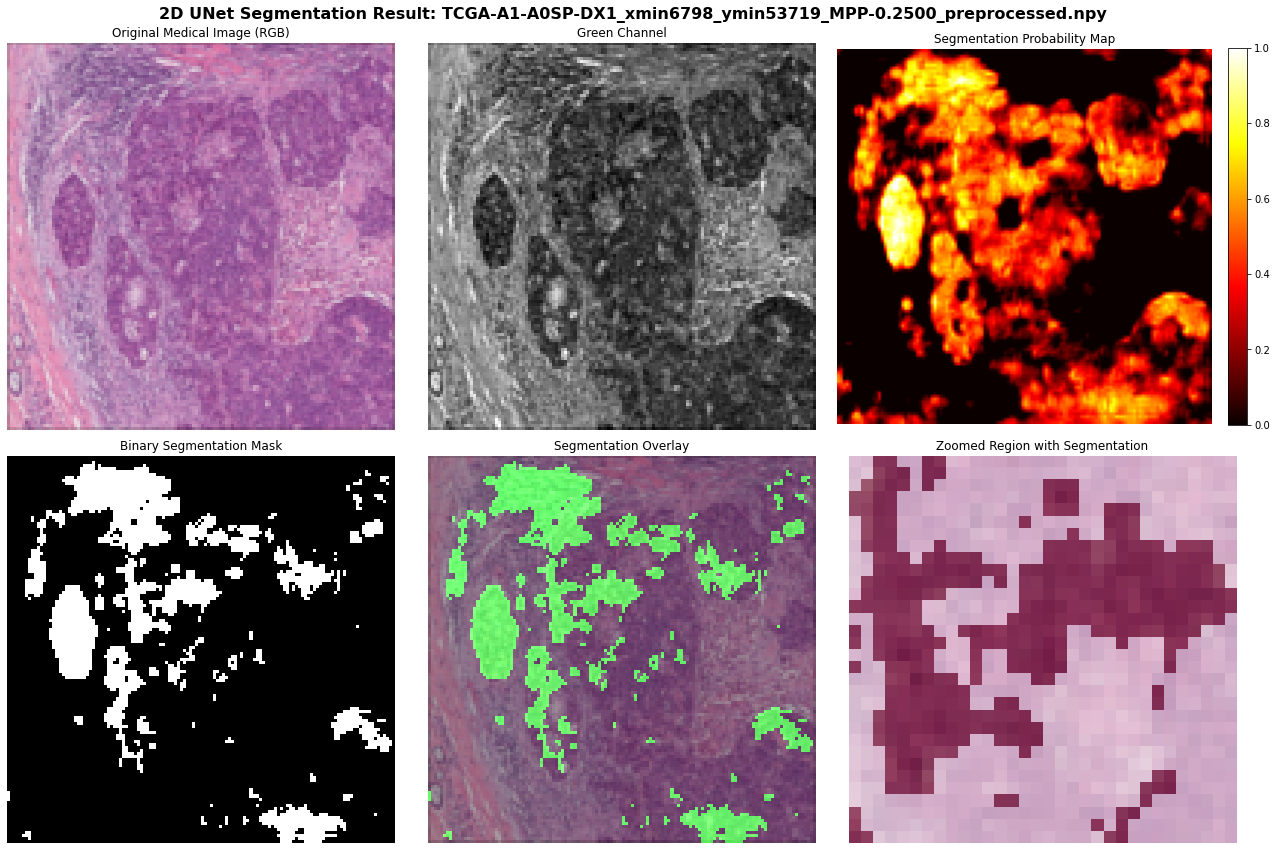

Processing Images:  10%|█         | 2/20 [00:15<02:21,  7.85s/image]

 TCGA-A1-A0SP-DX1_xmin6798_ymin53719_MPP-0.2500_preprocessed.npy: Inference=6.7ms, Coverage=17.0%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A04P-DX1_xmin104246_ymin48517_MPP-0.2500_preprocessed_visualization.png


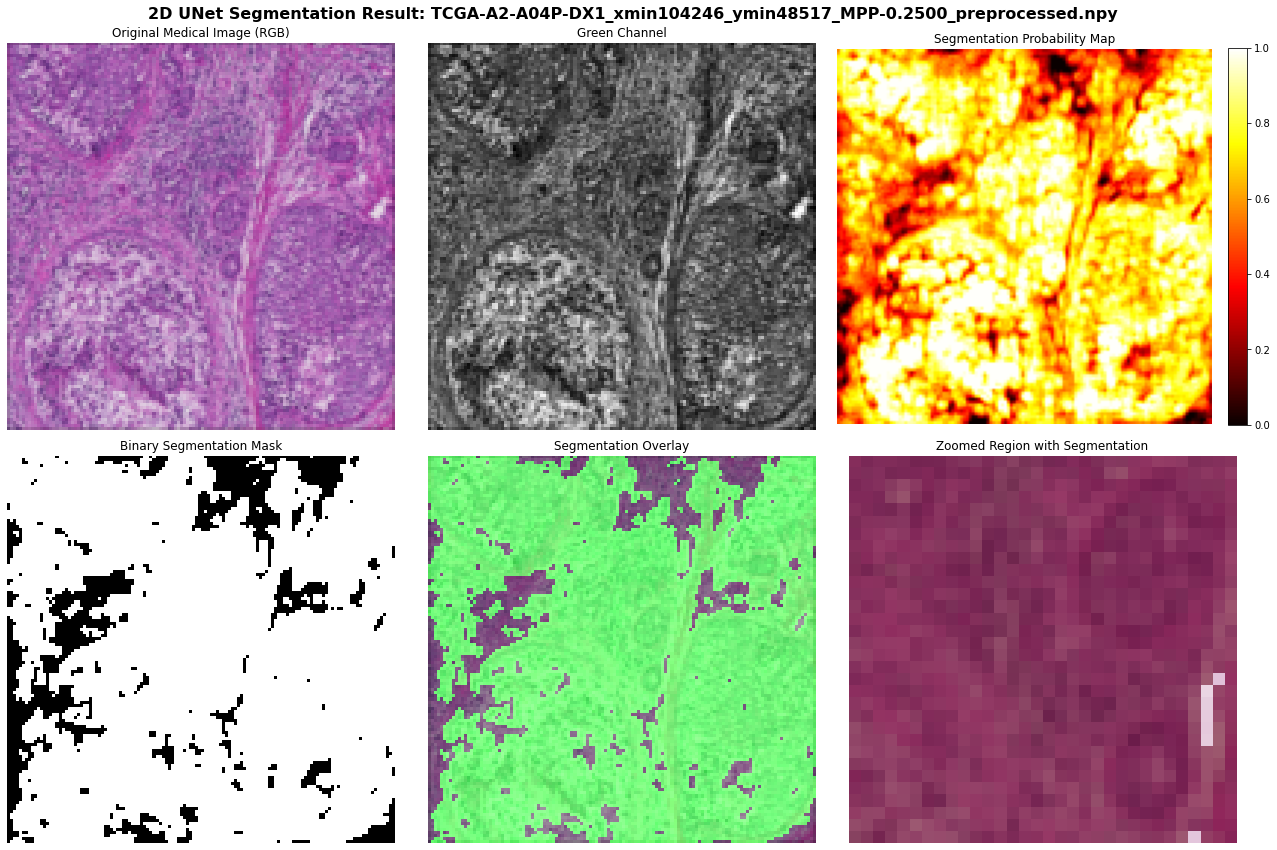

Processing Images:  15%|█▌        | 3/20 [00:23<02:11,  7.72s/image]

 TCGA-A2-A04P-DX1_xmin104246_ymin48517_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=84.2%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500_preprocessed_visualization.png


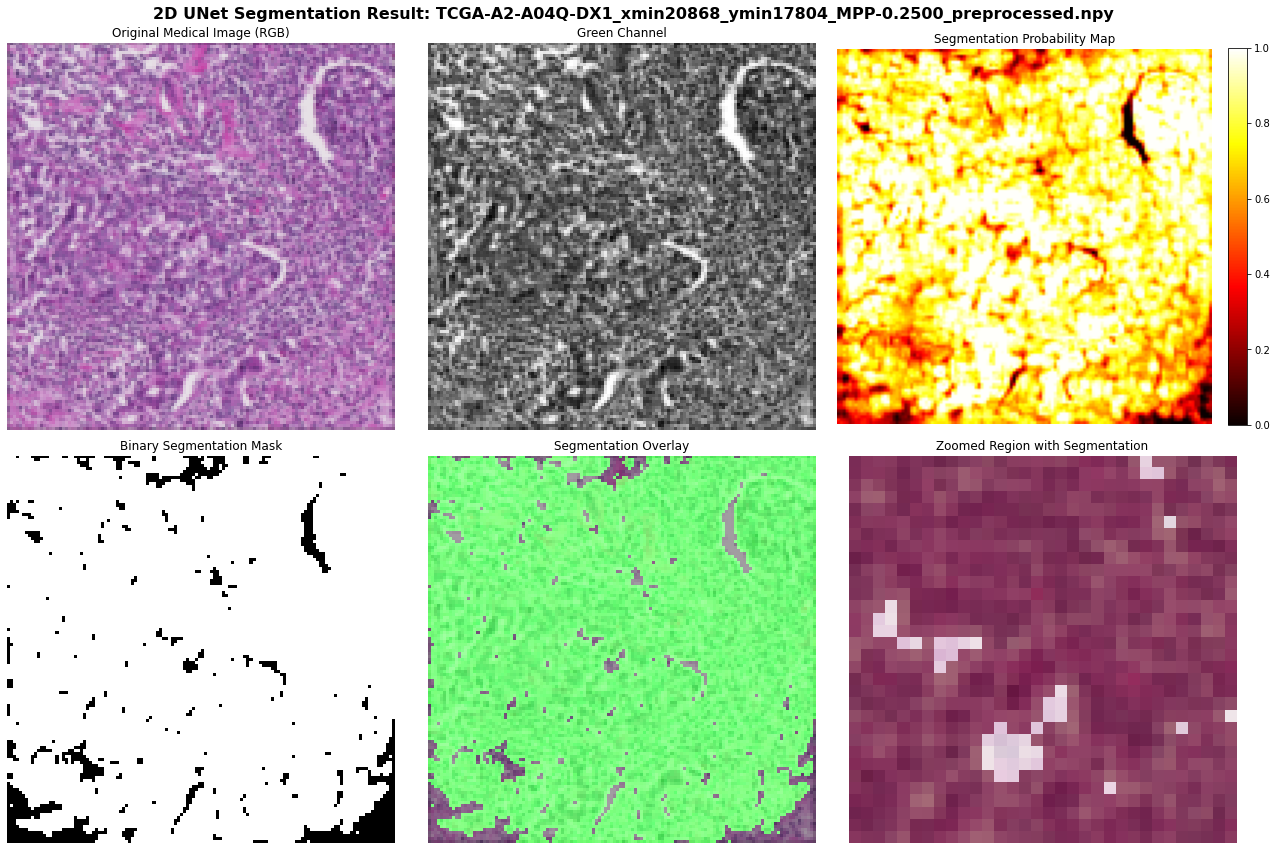

Processing Images:  20%|██        | 4/20 [00:30<02:02,  7.68s/image]

 TCGA-A2-A04Q-DX1_xmin20868_ymin17804_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=91.8%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2500_preprocessed_visualization.png


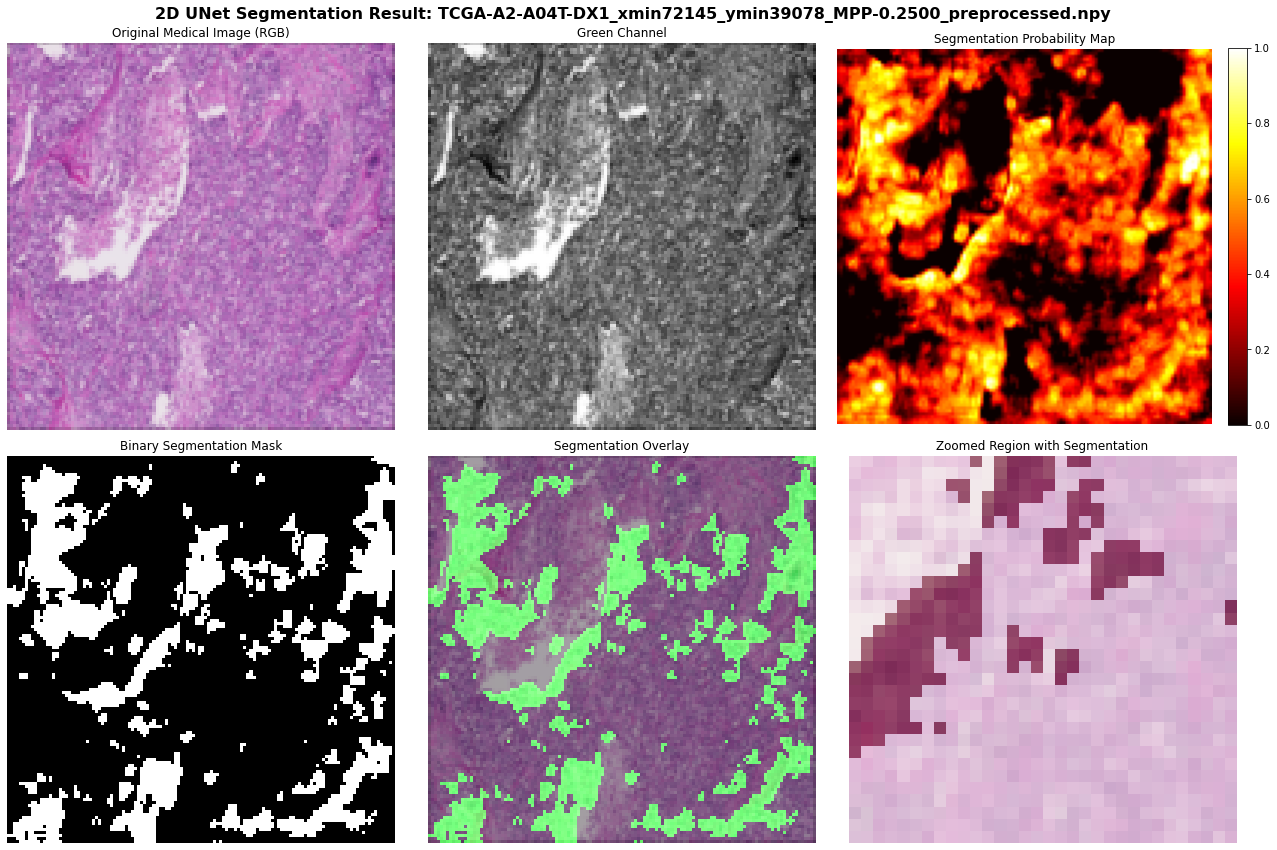

Processing Images:  25%|██▌       | 5/20 [00:38<01:57,  7.81s/image]

 TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=24.9%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0CM-DX1_xmin18562_ymin56852_MPP-0.2500_preprocessed_visualization.png


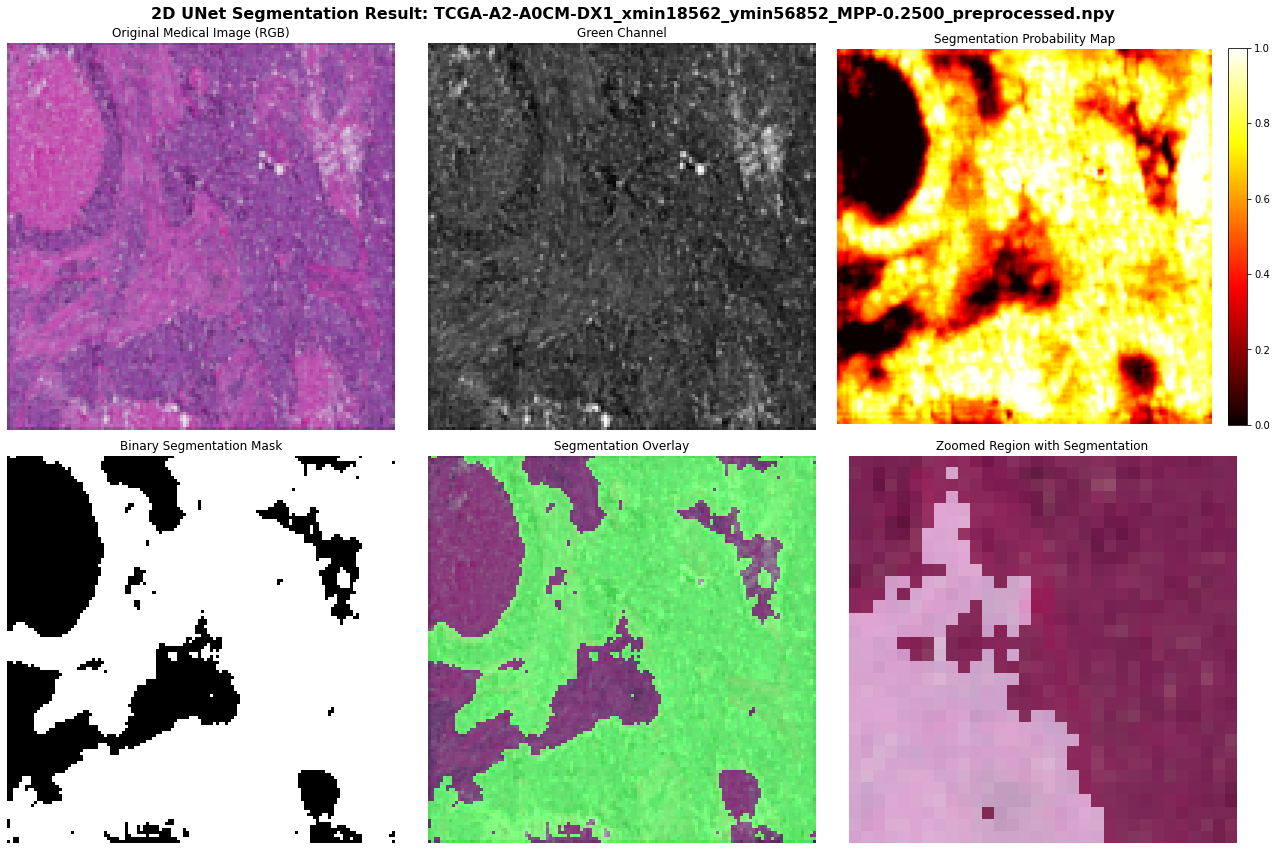

Processing Images:  30%|███       | 6/20 [00:46<01:47,  7.70s/image]

 TCGA-A2-A0CM-DX1_xmin18562_ymin56852_MPP-0.2500_preprocessed.npy: Inference=6.6ms, Coverage=72.6%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0D0-DX1_xmin68482_ymin39071_MPP-0.2500_preprocessed_visualization.png


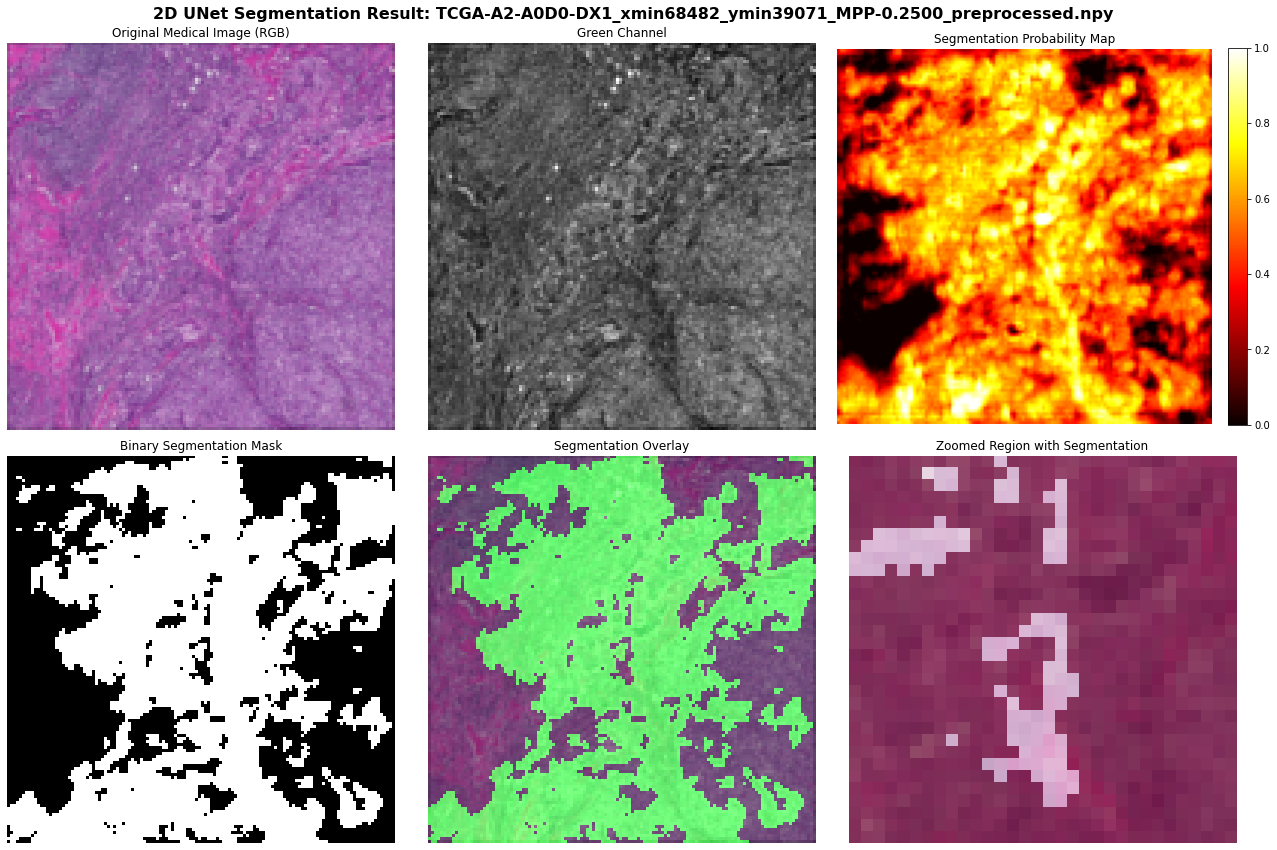

Processing Images:  35%|███▌      | 7/20 [00:53<01:39,  7.62s/image]

 TCGA-A2-A0D0-DX1_xmin68482_ymin39071_MPP-0.2500_preprocessed.npy: Inference=6.7ms, Coverage=56.5%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0D2-DX1_xmin96887_ymin22299_MPP-0.2500_preprocessed_visualization.png


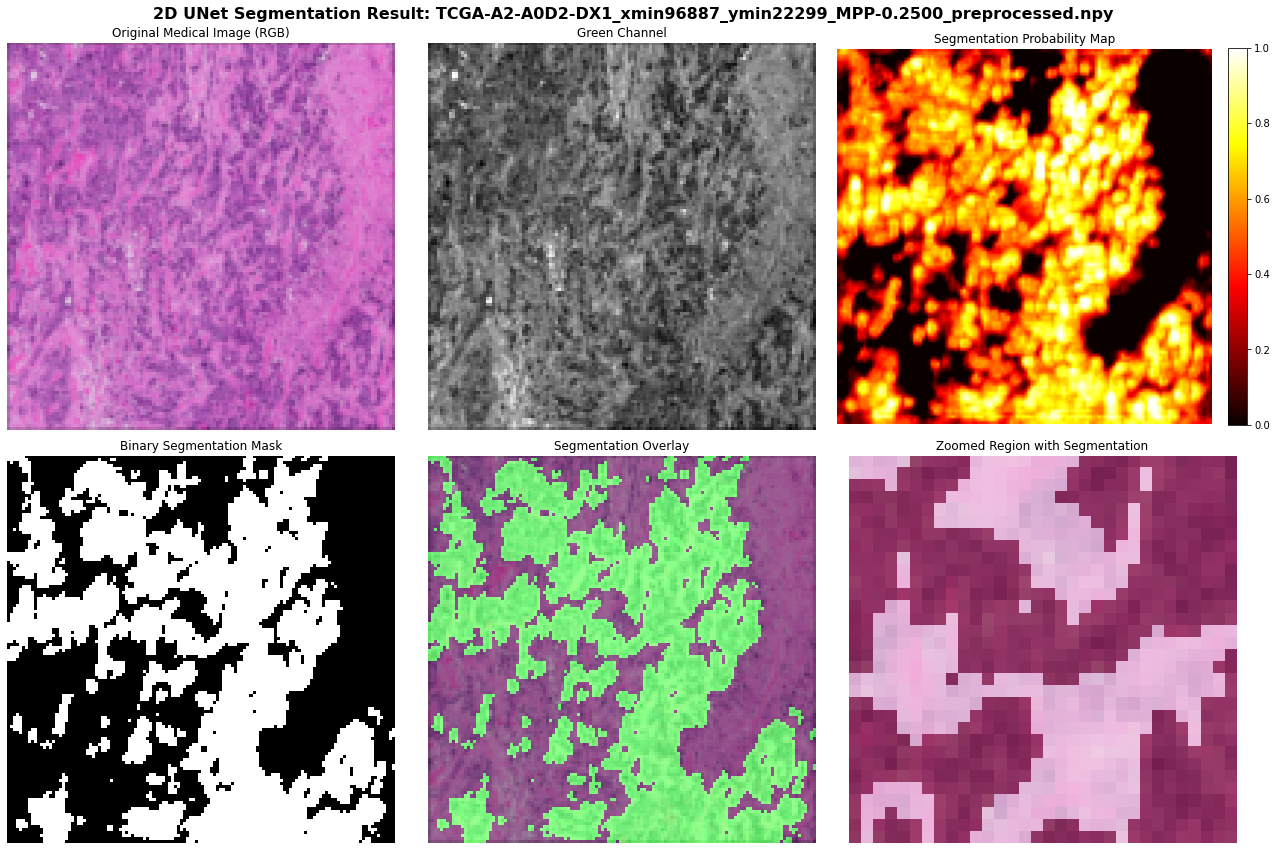

Processing Images:  40%|████      | 8/20 [01:01<01:33,  7.76s/image]

 TCGA-A2-A0D2-DX1_xmin96887_ymin22299_MPP-0.2500_preprocessed.npy: Inference=6.6ms, Coverage=47.7%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0ST-DX1_xmin109446_ymin18274_MPP-0.2500_preprocessed_visualization.png


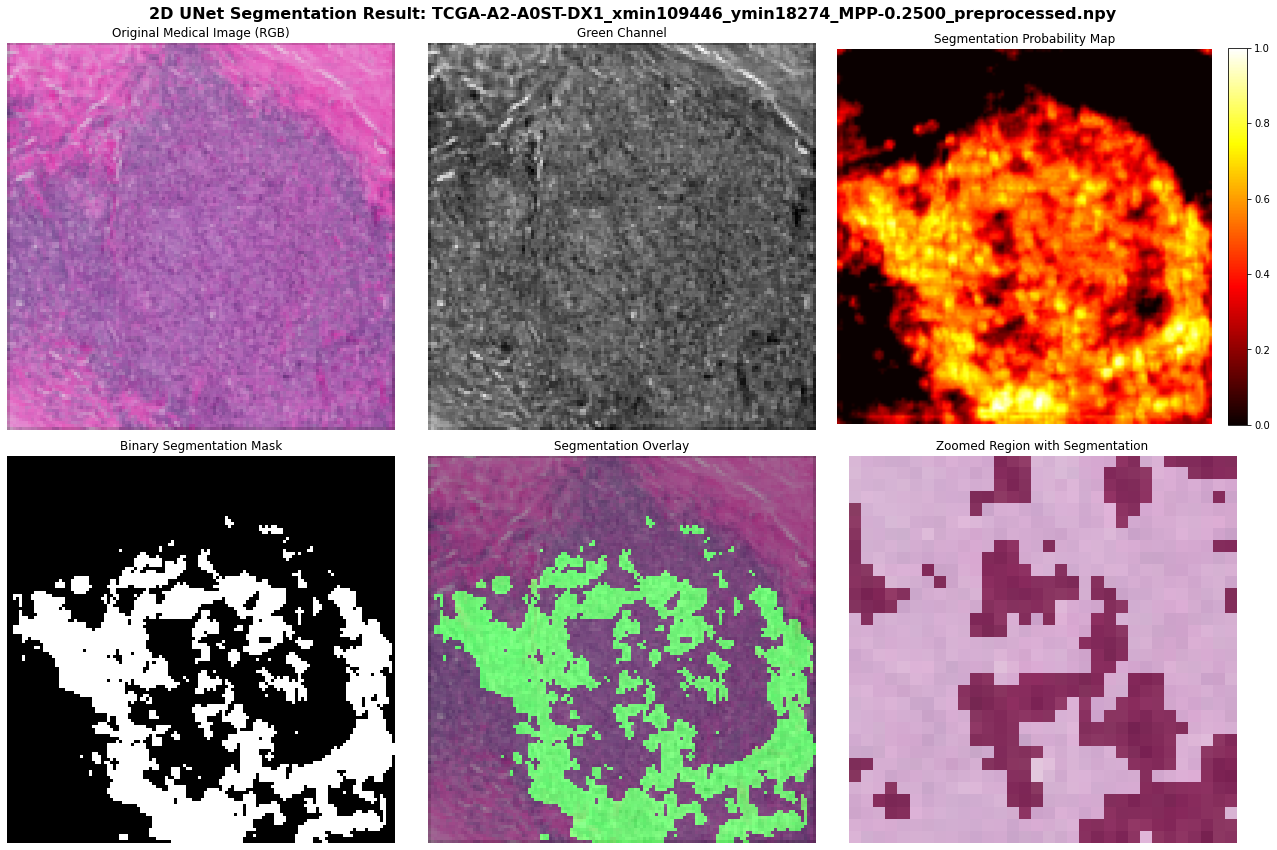

Processing Images:  45%|████▌     | 9/20 [01:09<01:24,  7.65s/image]

 TCGA-A2-A0ST-DX1_xmin109446_ymin18274_MPP-0.2500_preprocessed.npy: Inference=6.6ms, Coverage=30.1%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0SX-DX1_xmin53791_ymin56683_MPP-0.2500_preprocessed_visualization.png


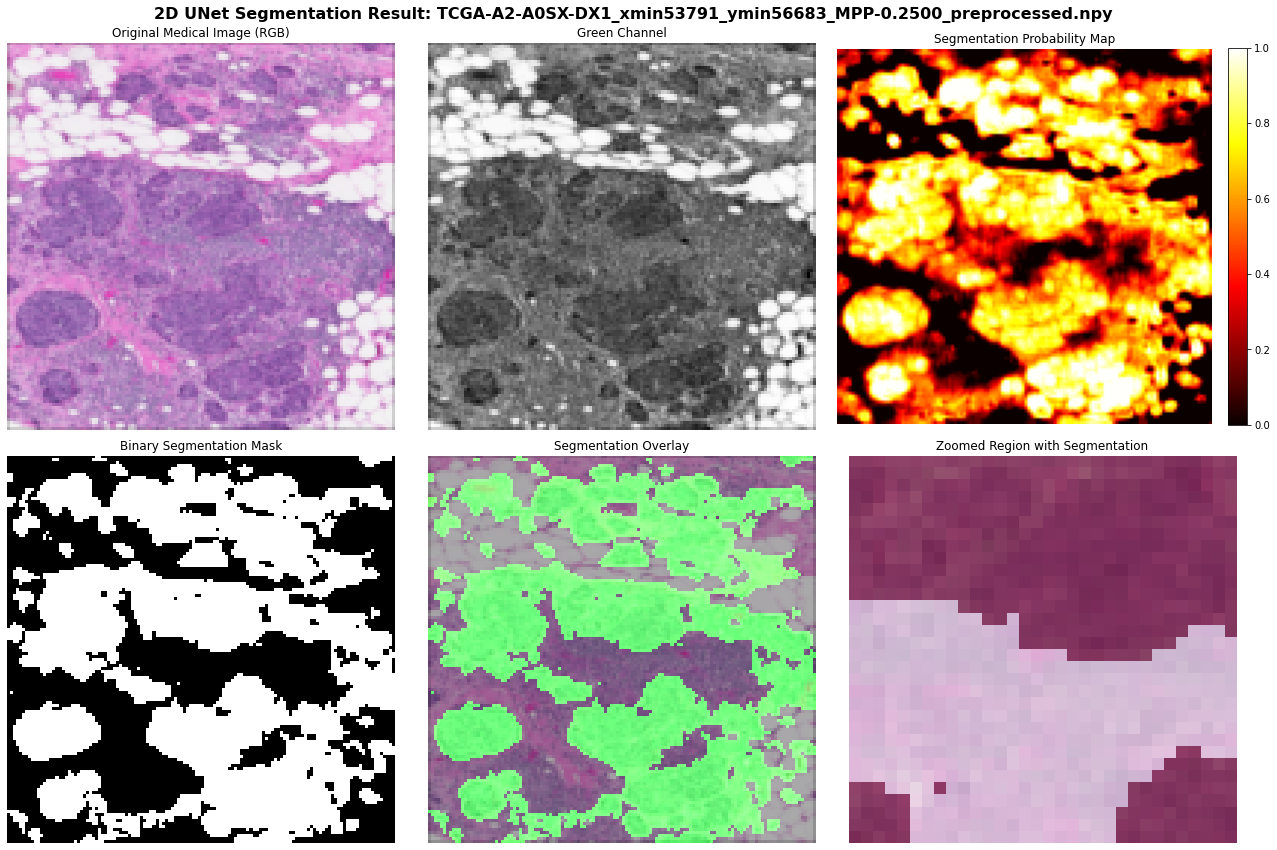

Processing Images:  50%|█████     | 10/20 [01:16<01:15,  7.60s/image]

 TCGA-A2-A0SX-DX1_xmin53791_ymin56683_MPP-0.2500_preprocessed.npy: Inference=6.6ms, Coverage=53.4%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0T0-DX1_xmin72865_ymin59458_MPP-0.2500_preprocessed_visualization.png


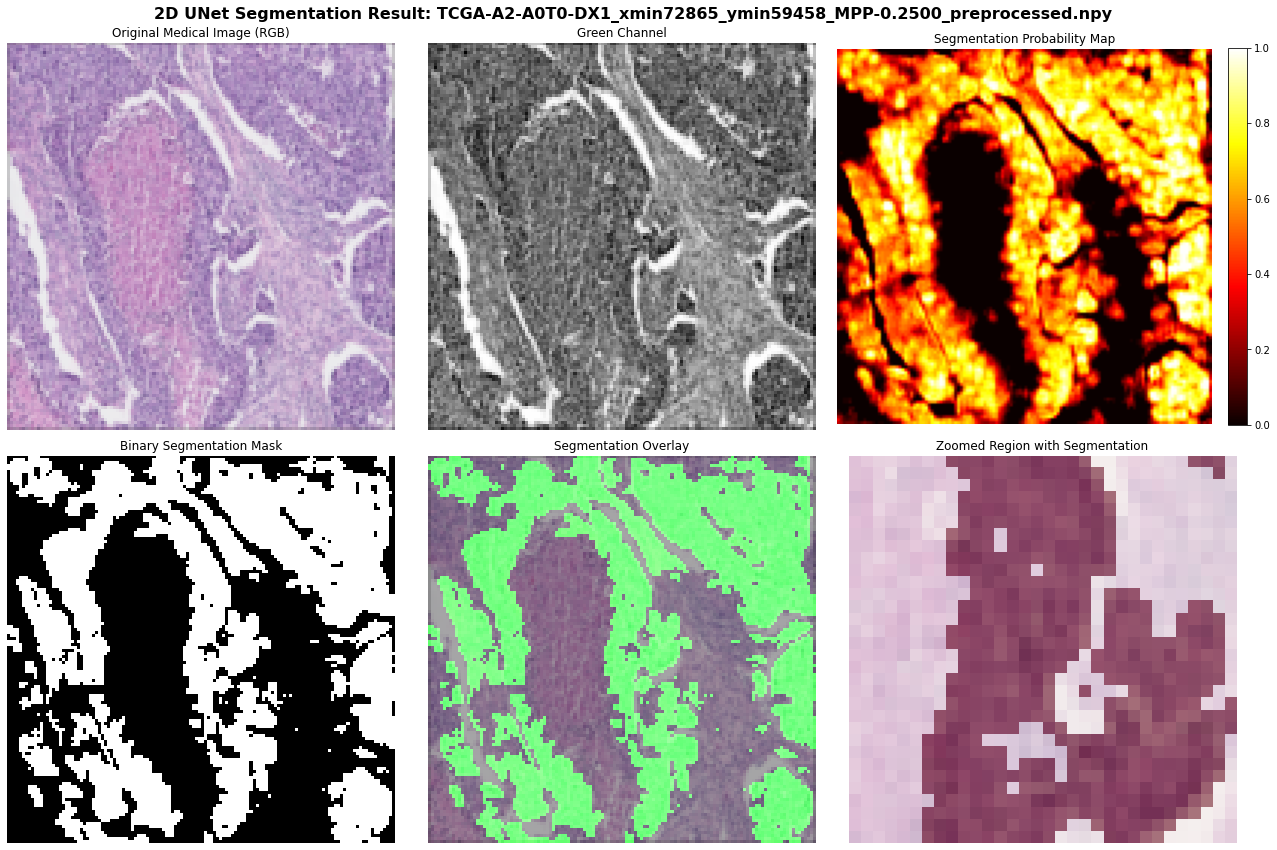

Processing Images:  55%|█████▌    | 11/20 [01:24<01:09,  7.75s/image]

 TCGA-A2-A0T0-DX1_xmin72865_ymin59458_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=47.4%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0T2-DX1_xmin63557_ymin56751_MPP-0.2500_preprocessed_visualization.png


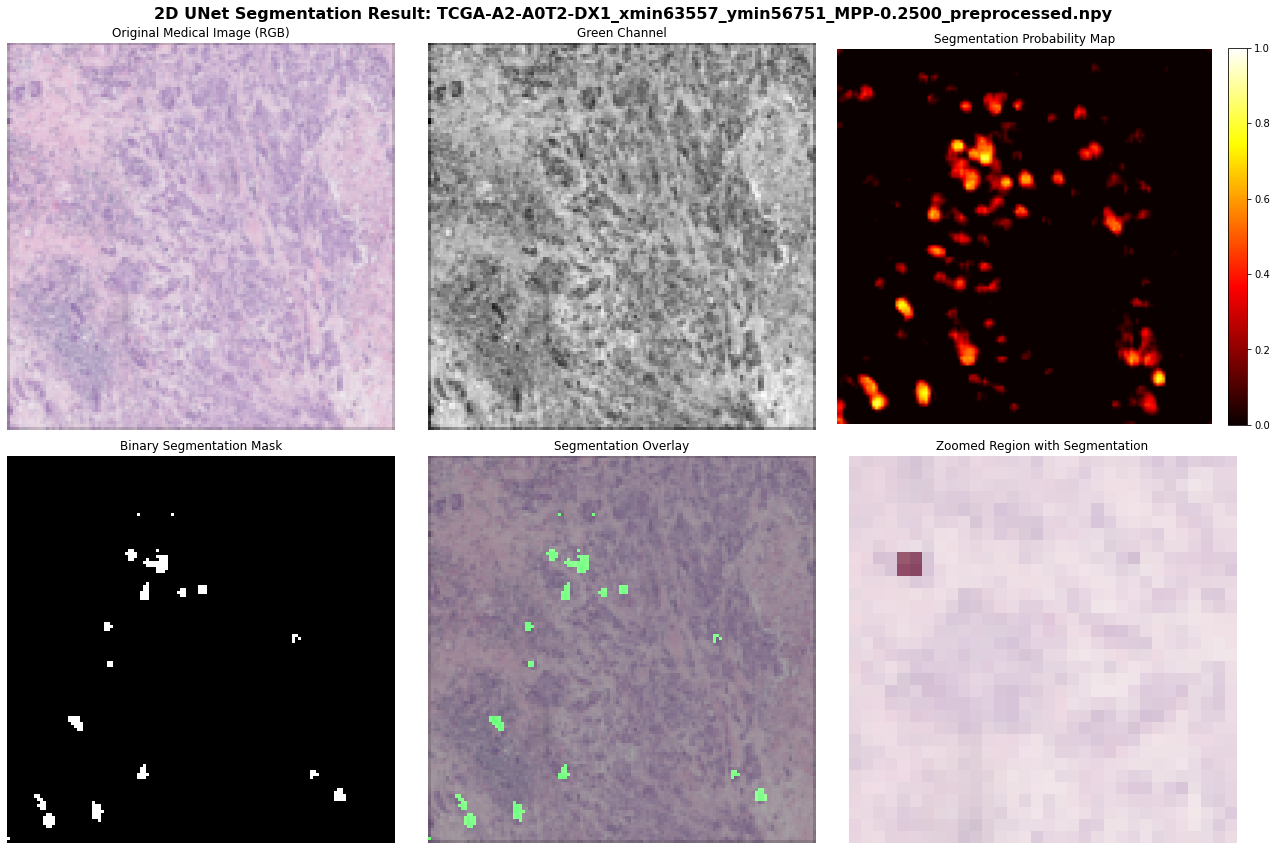

Processing Images:  60%|██████    | 12/20 [01:32<01:00,  7.59s/image]

 TCGA-A2-A0T2-DX1_xmin63557_ymin56751_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=1.1%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0YE-DX1_xmin59206_ymin33505_MPP-0.2500_preprocessed_visualization.png


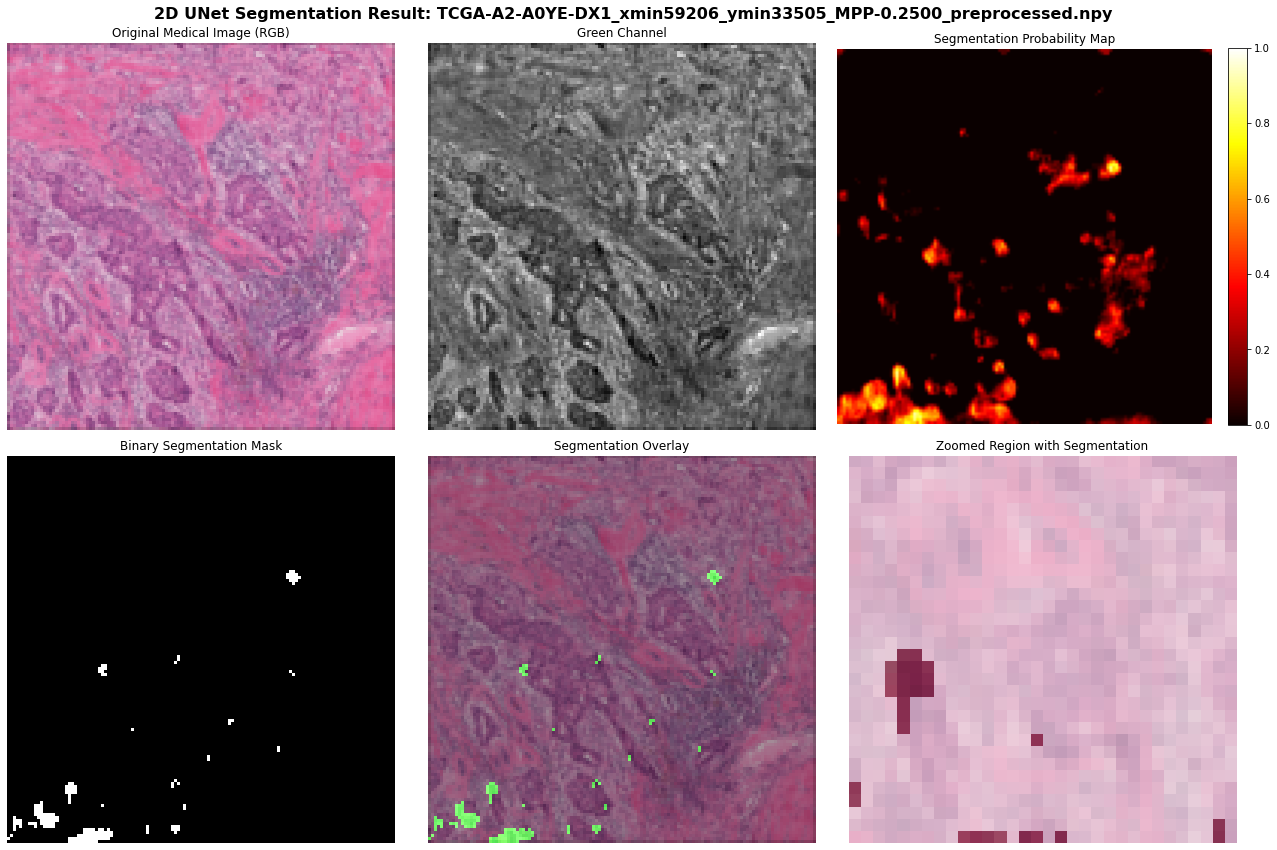

Processing Images:  65%|██████▌   | 13/20 [01:39<00:52,  7.49s/image]

 TCGA-A2-A0YE-DX1_xmin59206_ymin33505_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=1.1%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A0YM-DX1_xmin44520_ymin66915_MPP-0.2500_preprocessed_visualization.png


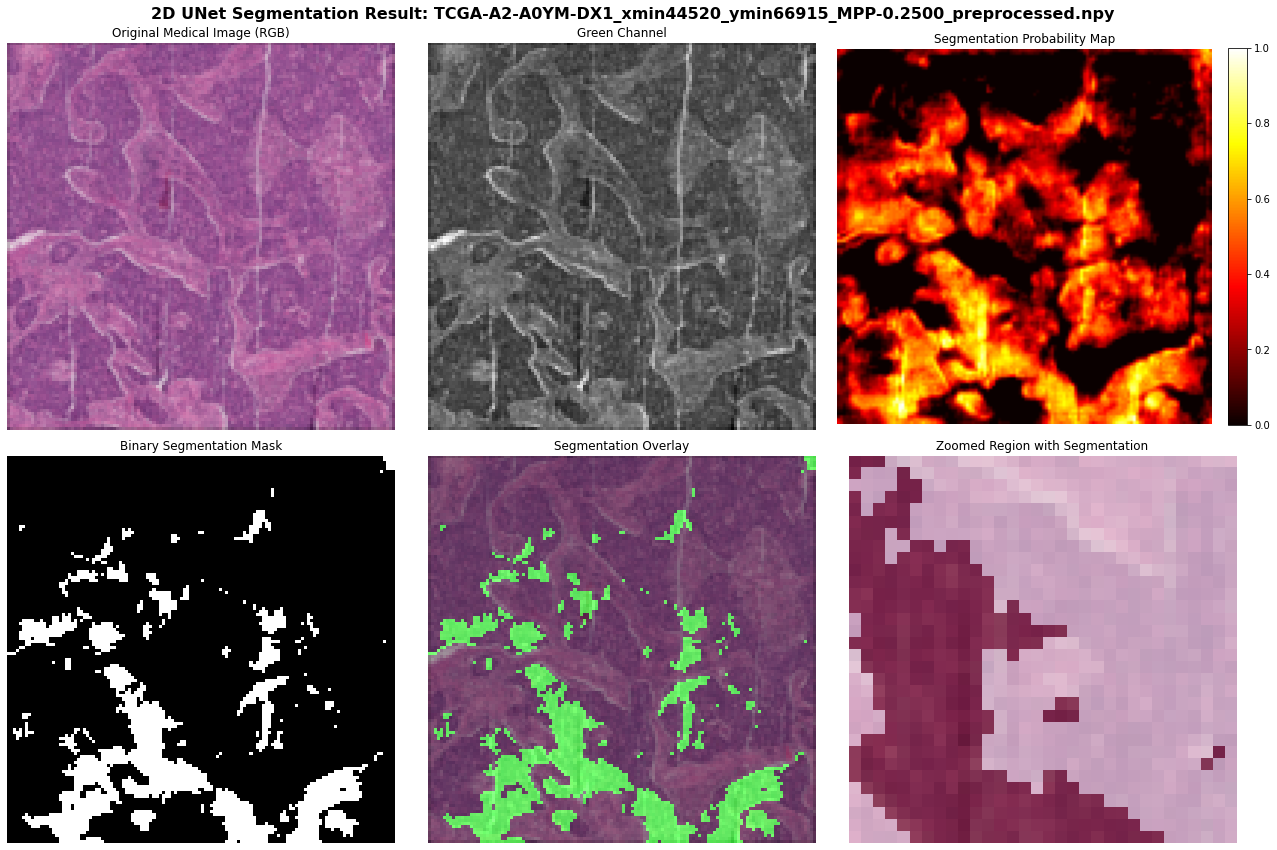

Processing Images:  70%|███████   | 14/20 [01:47<00:45,  7.67s/image]

 TCGA-A2-A0YM-DX1_xmin44520_ymin66915_MPP-0.2500_preprocessed.npy: Inference=6.7ms, Coverage=15.3%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A1G6-DX1_xmin57706_ymin69514_MPP-0.2500_preprocessed_visualization.png


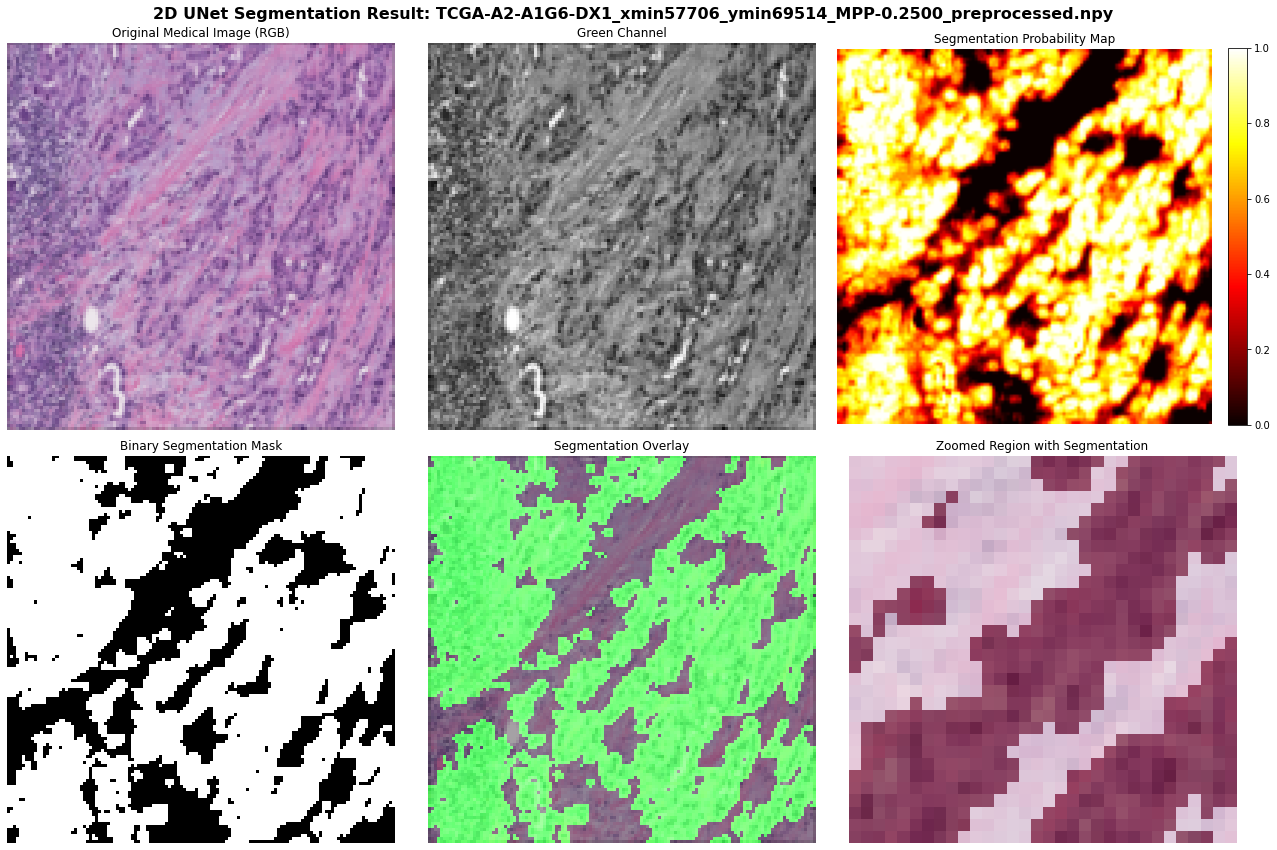

Processing Images:  75%|███████▌  | 15/20 [01:54<00:38,  7.62s/image]

 TCGA-A2-A1G6-DX1_xmin57706_ymin69514_MPP-0.2500_preprocessed.npy: Inference=6.6ms, Coverage=66.5%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A3XS-DX1_xmin21421_ymin37486_MPP-0.2500_preprocessed_visualization.png


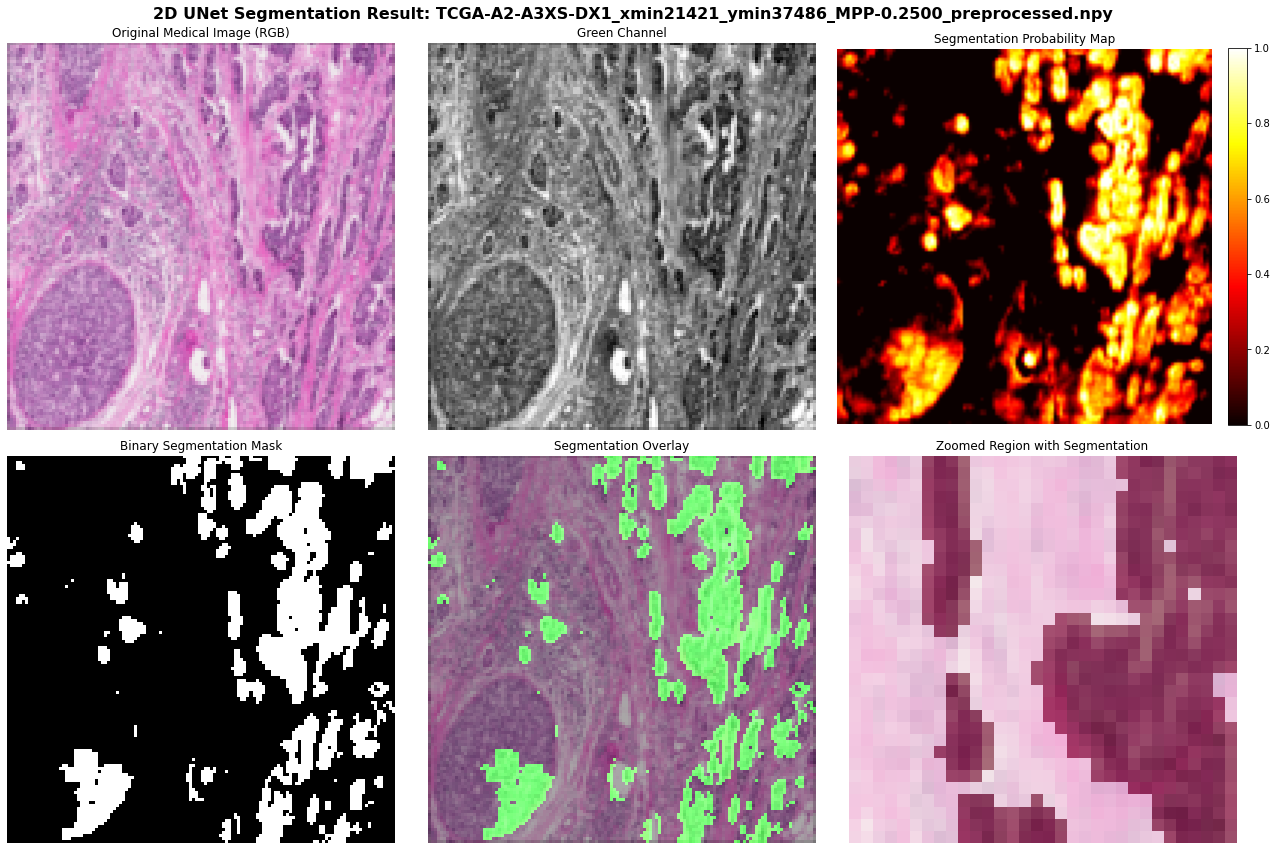

Processing Images:  80%|████████  | 16/20 [02:02<00:30,  7.56s/image]

 TCGA-A2-A3XS-DX1_xmin21421_ymin37486_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=20.6%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A3XT-DX1_xmin83566_ymin29931_MPP-0.2500_preprocessed_visualization.png


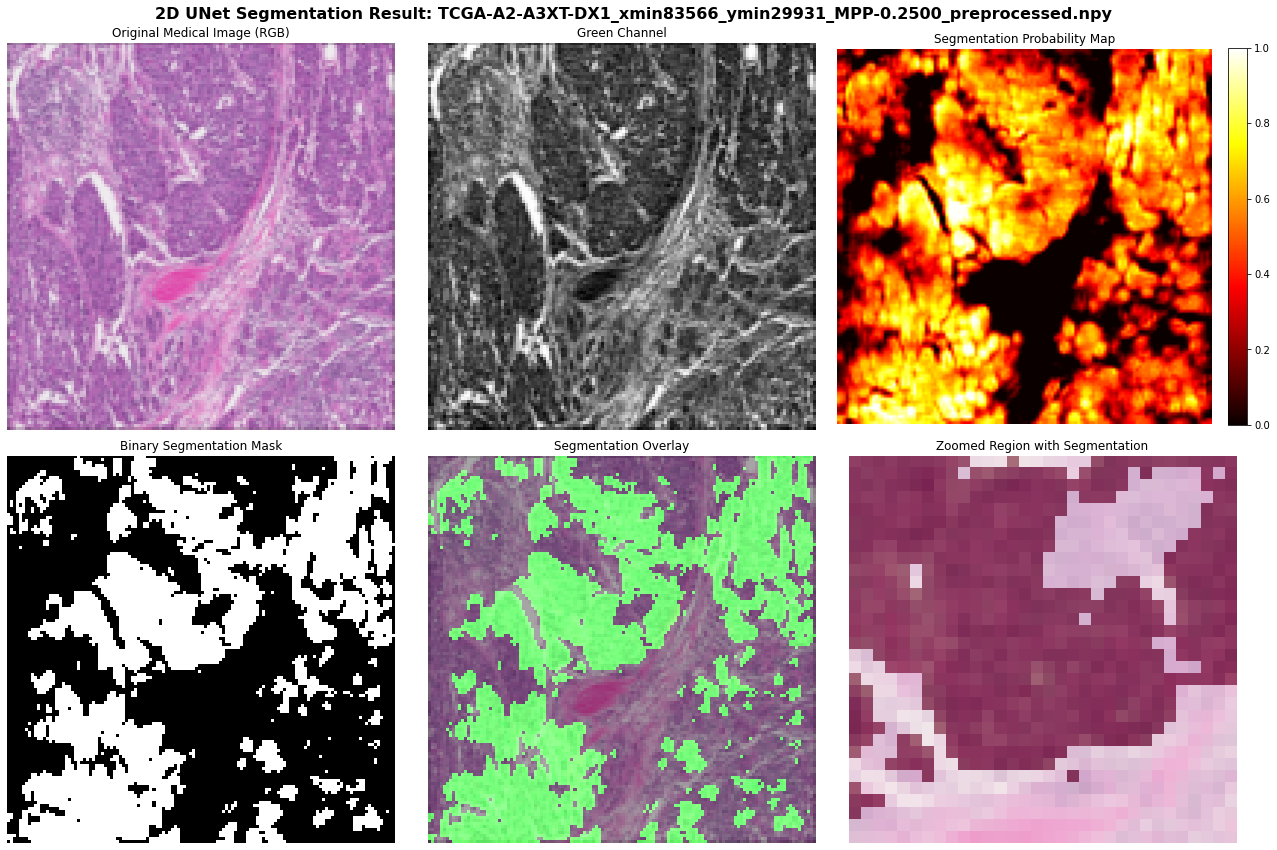

Processing Images:  85%|████████▌ | 17/20 [02:10<00:23,  7.72s/image]

 TCGA-A2-A3XT-DX1_xmin83566_ymin29931_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=41.0%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A3XU-DX1_xmin33329_ymin26157_MPP-0.2500_preprocessed_visualization.png


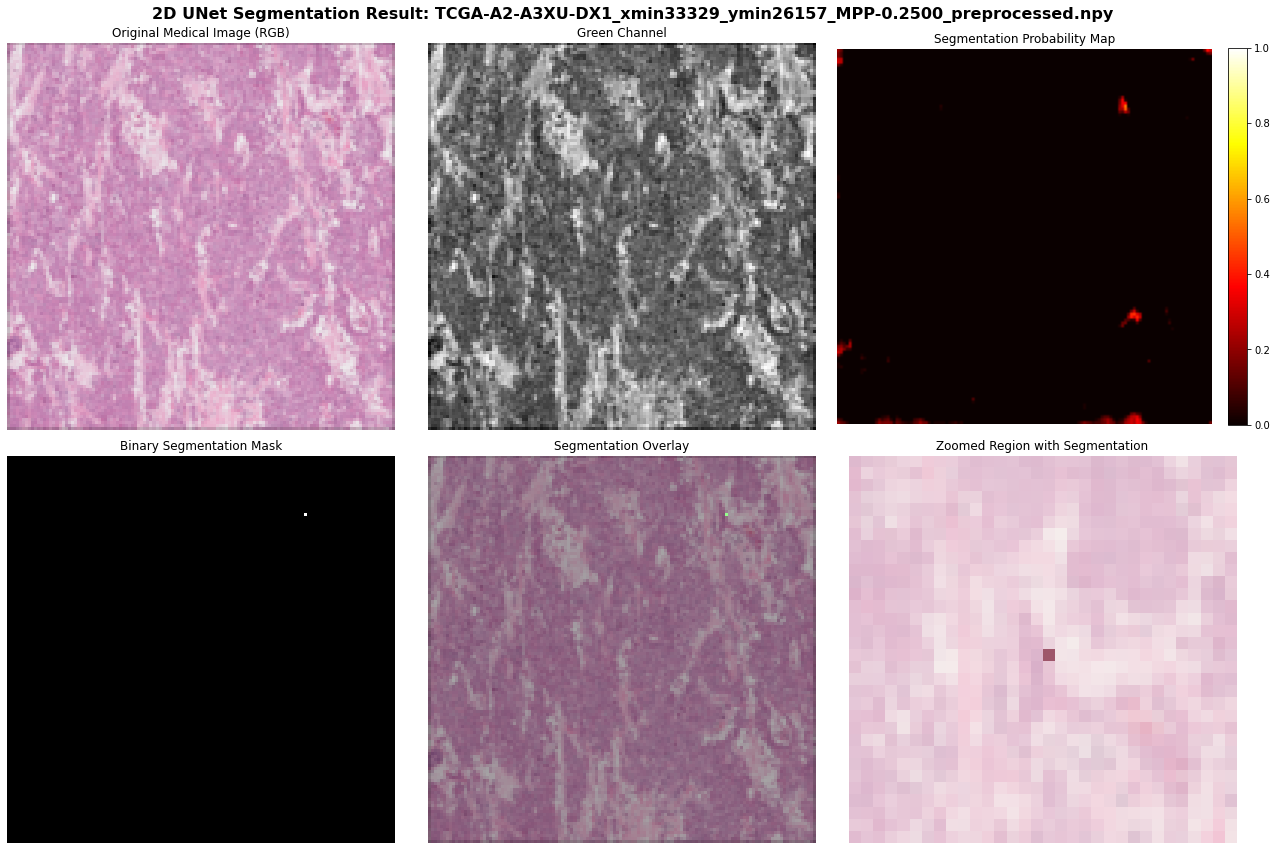

Processing Images:  90%|█████████ | 18/20 [02:17<00:15,  7.55s/image]

 TCGA-A2-A3XU-DX1_xmin33329_ymin26157_MPP-0.2500_preprocessed.npy: Inference=6.9ms, Coverage=0.0%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500_preprocessed_visualization.png


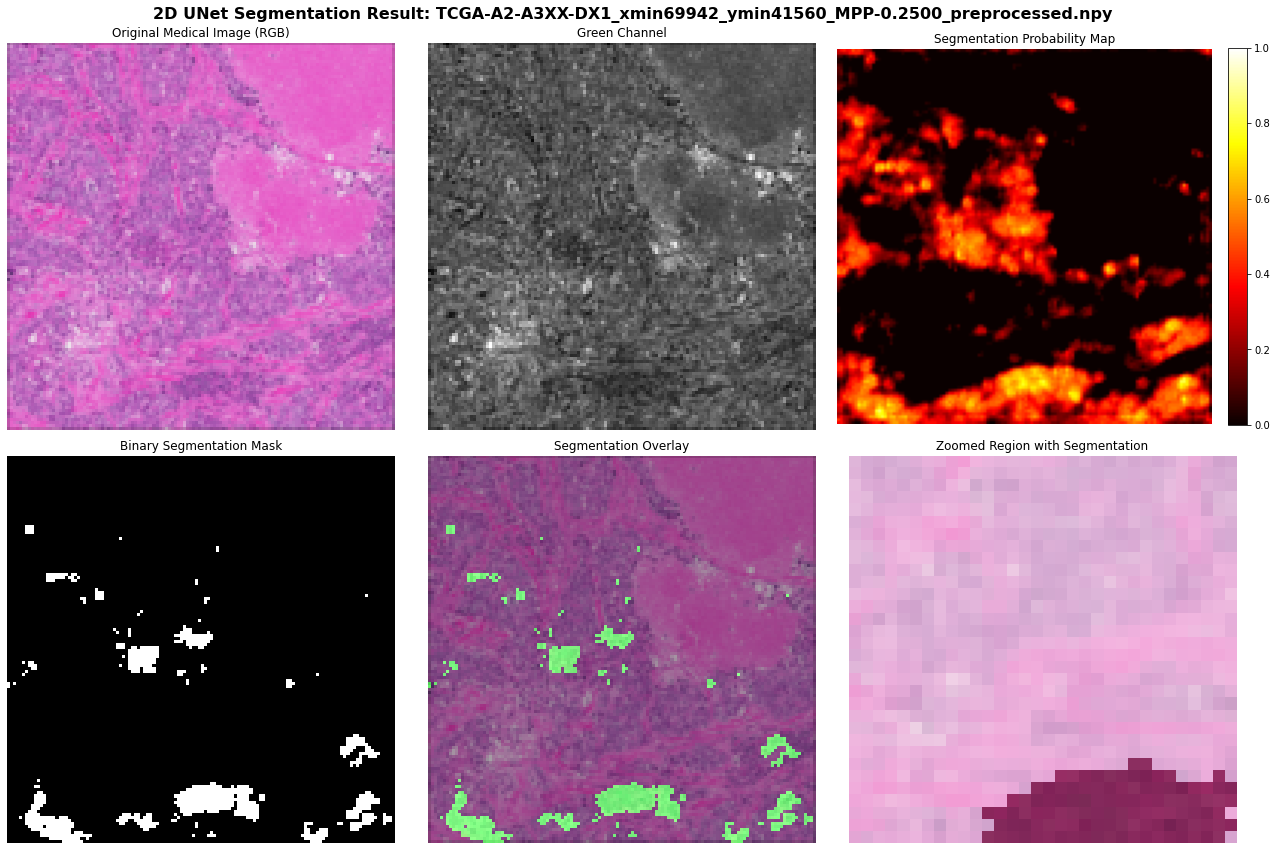

Processing Images:  95%|█████████▌| 19/20 [02:24<00:07,  7.48s/image]

 TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=5.2%
 Visualization saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/visualizations/TCGA-A2-A3XY-DX1_xmin76297_ymin35510_MPP-0.2500_preprocessed_visualization.png


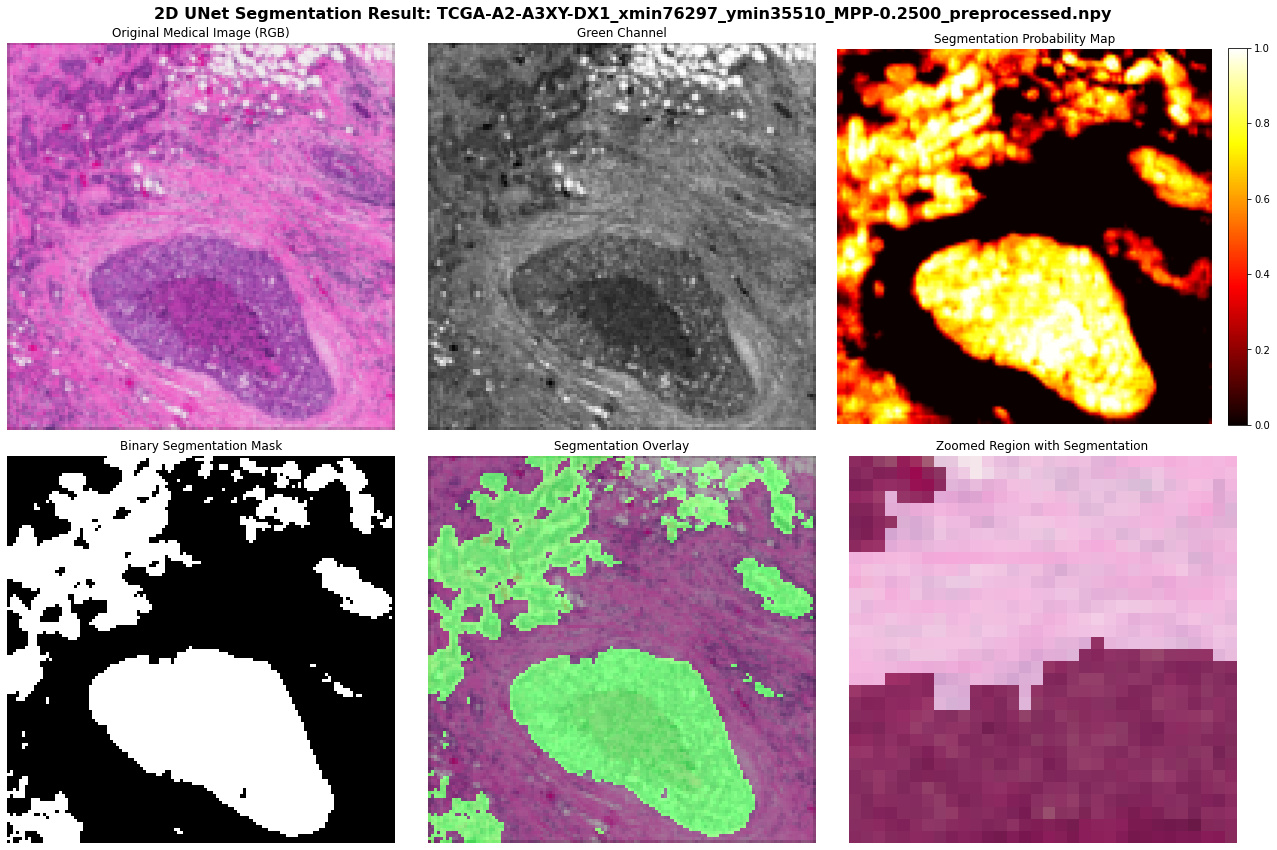

Processing Images: 100%|██████████| 20/20 [02:32<00:00,  7.65s/image]

 TCGA-A2-A3XY-DX1_xmin76297_ymin35510_MPP-0.2500_preprocessed.npy: Inference=6.5ms, Coverage=39.2%
 Processing session ended: 2025-11-01 11:01:41
 Total session time: 152.95 seconds


In [9]:
def batch_process_images():
    """Main batch processing function"""
    
    # Create output directory structure
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    output_masks_dir = os.path.join(OUTPUT_DIR, 'binary_masks')
    output_probs_dir = os.path.join(OUTPUT_DIR, 'probability_maps')
    output_visuals_dir = os.path.join(OUTPUT_DIR, 'visualizations')
    os.makedirs(output_masks_dir, exist_ok=True)
    os.makedirs(output_probs_dir, exist_ok=True)
    os.makedirs(output_visuals_dir, exist_ok=True)
    
    # Get all NPY files
    npy_files = sorted(glob.glob(os.path.join(INPUT_DIR, "*.npy")))
    
    if not npy_files:
        print(f" Error: No NPY files found in {INPUT_DIR}")
        return None
    
    print(f"\n Found {len(npy_files)} image files for processing")
    print(f" Input directory: {INPUT_DIR}")
    print(f" Output directory: {OUTPUT_DIR}")
    
    # Initialize performance monitoring
    perf_monitor = PerformanceMonitor()
    perf_monitor.start_session()
    
    print(f"\n Starting batch processing...")
    print("="*80)
    
    # Use tqdm for progress bar
    for npy_file in tqdm(npy_files, desc="Processing Images", unit="image",
                         bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"):
        file_name = os.path.basename(npy_file)
        file_base = os.path.splitext(file_name)[0]
        
        try:
            # Record single image processing start time
            img_start_time = time.time()
            
            # Load image
            input_image = np.load(npy_file)
            
            # Preprocessing
            preprocess_start = time.time()
            preprocessed_input = preprocess_medical_image(input_image, shapeIn)
            image_buffer[0] = preprocessed_input[0]
            preprocess_time = time.time() - preprocess_start
            
            # DPU inference
            inference_start = time.time()
            job_id = dpu.execute_async(input_data, output_data)
            dpu.wait(job_id)
            inference_time = time.time() - inference_start
            
            # Postprocessing
            postprocess_start = time.time()
            raw_output = output_data[0].copy()
            binary_mask, probability_map = postprocess_segmentation(raw_output)
            postprocess_time = time.time() - postprocess_start
            
            # Calculate total time
            total_time = time.time() - img_start_time
            
            # Calculate segmentation statistics
            seg_pixels = np.sum(binary_mask)
            coverage = (seg_pixels / binary_mask.size) * 100
            
            # Save results
            mask_path = os.path.join(output_masks_dir, f"{file_base}_binary_mask.npy")
            prob_path = os.path.join(output_probs_dir, f"{file_base}_probability_map.npy")
            np.save(mask_path, binary_mask)
            np.save(prob_path, probability_map)
            
            # Generate visualization for first few images
            if len(perf_monitor.file_names) < MAX_VISUALIZATIONS:
                visualize_segmentation_result(
                    input_image, probability_map, binary_mask,
                    file_name, output_visuals_dir
                )
            
            # Record performance statistics
            perf_monitor.add_record(
                file_name, preprocess_time, inference_time,
                postprocess_time, total_time, seg_pixels, coverage
            )
            
            # Real-time processing info
            tqdm.write(f" {file_name}: Inference={inference_time*1000:.1f}ms, Coverage={coverage:.1f}%")
            
        except Exception as e:
            tqdm.write(f" Error processing {file_name}: {e}")
            continue
    
    # End performance monitoring
    perf_monitor.end_session()
    
    return perf_monitor

# Execute batch processing
print(" Starting batch processing execution...")
performance_monitor = batch_process_images()

## 8. Performance Analysis and Results

Analyze the batch processing results and generate comprehensive performance reports.

In [10]:
# Print detailed performance report
if performance_monitor:
    performance_monitor.print_detailed_report()
    
    # Get statistics for summary
    stats = performance_monitor.get_statistics()
    
    if stats:
        print(f"\n Batch Processing Completed Successfully!")
        print(f" Summary Statistics:")
        print(f"  ├─ Total images processed: {stats['total_images']}")
        print(f"  ├─ Average inference time: {stats['avg_inference_time']*1000:.2f} ms")
        print(f"  ├─ Average throughput: {stats['throughput_fps']:.2f} FPS")
        print(f"  ├─ Average coverage: {stats['avg_coverage_percent']:.2f}%")
        print(f"  └─ Total processing time: {stats['total_elapsed_time']:.2f} seconds")
else:
    print(" No performance data available")


                          2D UNet Batch Processing Performance Report

 Processing Overview:
  ├─ Total images processed: 20
  ├─ Total session time: 152.95 seconds
  ├─ Average throughput: 0.13 FPS
  └─ Processing speed: 7.8 images/minute

 Inference Performance (milliseconds):
  ├─ Average inference time: 6.62 ms
  ├─ Minimum inference time: 6.53 ms
  ├─ Maximum inference time: 6.88 ms
  └─ Standard deviation: 0.10 ms

 Processing Stage Time Analysis:
  ├─ Preprocessing: 0.34 ms (1.5%)
  ├─ Inference: 6.62 ms (29.6%)
  ├─ Postprocessing: 0.32 ms (1.5%)
  └─ Total: 22.34 ms

 Segmentation Quality Statistics:
  ├─ Average segmented pixels: 6339
  ├─ Average coverage: 38.69%
  ├─ Highest coverage: 91.85%
  └─ Lowest coverage: 0.01%

📈 Performance Stability:
  ├─ Inference time coefficient of variation: 1.53%
  └─ Assessment: Excellent (very stable)


 Batch Processing Completed Successfully!
 Summary Statistics:
  ├─ Total images processed: 20
  ├─ Average inference time: 6.62 ms
  ├─ 


 Generating performance analysis charts...
 Performance charts saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/performance_analysis_charts.png


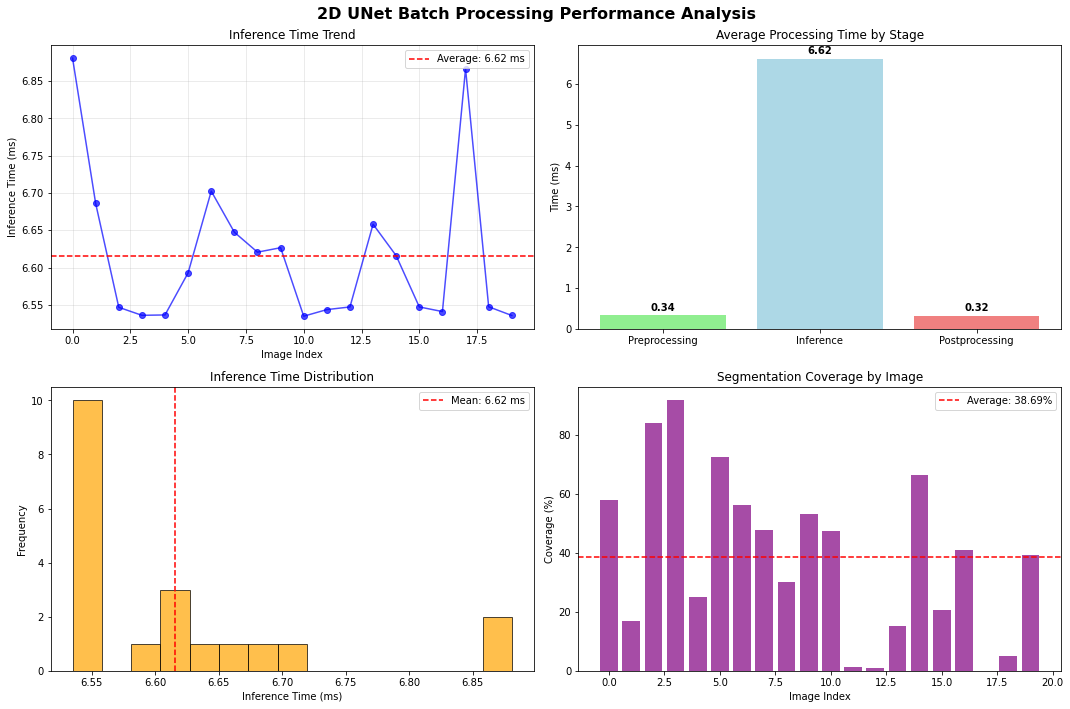

In [11]:
# Generate performance analysis charts
if performance_monitor and performance_monitor.inference_times:
    print("\n Generating performance analysis charts...")
    
    fig = plot_performance_charts(performance_monitor)
    
    if fig:
        # Save performance charts
        chart_path = os.path.join(OUTPUT_DIR, 'performance_analysis_charts.png')
        fig.savefig(chart_path, dpi=150, bbox_inches='tight')
        print(f" Performance charts saved: {chart_path}")
        plt.show()
else:
    print(" No performance data available for chart generation")

## 9. Save Results and Reports

Save comprehensive performance reports and processing results in multiple formats.

In [12]:
# Save detailed performance report to JSON
if performance_monitor:
    json_path = os.path.join(OUTPUT_DIR, 'performance_report.json')
    performance_monitor.save_to_json(json_path)
    
    # Save CSV format summary
    csv_path = os.path.join(OUTPUT_DIR, 'performance_summary.csv')
    with open(csv_path, 'w') as f:
        f.write("File Name,Preprocessing(ms),Inference(ms),Postprocessing(ms),Total(ms),Segmented Pixels,Coverage(%)\n")
        for i in range(len(performance_monitor.file_names)):
            f.write(f"{performance_monitor.file_names[i]},"
                   f"{performance_monitor.preprocessing_times[i]*1000:.2f},"
                   f"{performance_monitor.inference_times[i]*1000:.2f},"
                   f"{performance_monitor.postprocessing_times[i]*1000:.2f},"
                   f"{performance_monitor.total_times[i]*1000:.2f},"
                   f"{performance_monitor.segmentation_stats[i]['segmented_pixels']:.0f},"
                   f"{performance_monitor.segmentation_stats[i]['coverage_percent']:.2f}\n")
    print(f" CSV report saved: {csv_path}")
    
    # Display file summary
    print(f"\n Generated Files Summary:")
    print(f"  ├─ Binary masks: {len(os.listdir(os.path.join(OUTPUT_DIR, 'binary_masks')))} files")
    print(f"  ├─ Probability maps: {len(os.listdir(os.path.join(OUTPUT_DIR, 'probability_maps')))} files")
    print(f"  ├─ Visualizations: {len(os.listdir(os.path.join(OUTPUT_DIR, 'visualizations')))} files")
    print(f"  ├─ Performance report (JSON): performance_report.json")
    print(f"  ├─ Performance summary (CSV): performance_summary.csv")
    print(f"  └─ Performance charts: performance_analysis_charts.png")
else:
    print(" No performance data to save")

 Performance report saved to: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/performance_report.json
 CSV report saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/performance_summary.csv

 Generated Files Summary:
  ├─ Binary masks: 20 files
  ├─ Probability maps: 20 files
  ├─ Visualizations: 21 files
  ├─ Performance report (JSON): performance_report.json
  ├─ Performance summary (CSV): performance_summary.csv
  └─ Performance charts: performance_analysis_charts.png


## 10. Result Summary and Quality Analysis

Analyze the segmentation quality and provide a comprehensive summary of the batch processing results.


                     Segmentation Quality Analysis

 Coverage Statistics:
  ├─ Average coverage: 38.69%
  ├─ Median coverage: 40.12%
  ├─ Standard deviation: 27.35%
  ├─ Minimum coverage: 0.01%
  ├─ Maximum coverage: 91.85%
  └─ Coverage range: 91.84%

 Pixel Statistics:
  ├─ Average segmented pixels: 6339
  ├─ Median segmented pixels: 6572
  ├─ Standard deviation: 4480
  ├─ Minimum segmented pixels: 1
  └─ Maximum segmented pixels: 15048

 Quality Distribution:
  ├─ Low quality (<20%): 6 images (30.0%)
  ├─ Medium quality (20-50%): 7 images (35.0%)
  └─ High quality (≥50%): 7 images (35.0%)

 Quality analysis chart saved: /root/jupyter_notebooks/pynq-dputest/cell/batch_results/segmentation_quality_analysis.png


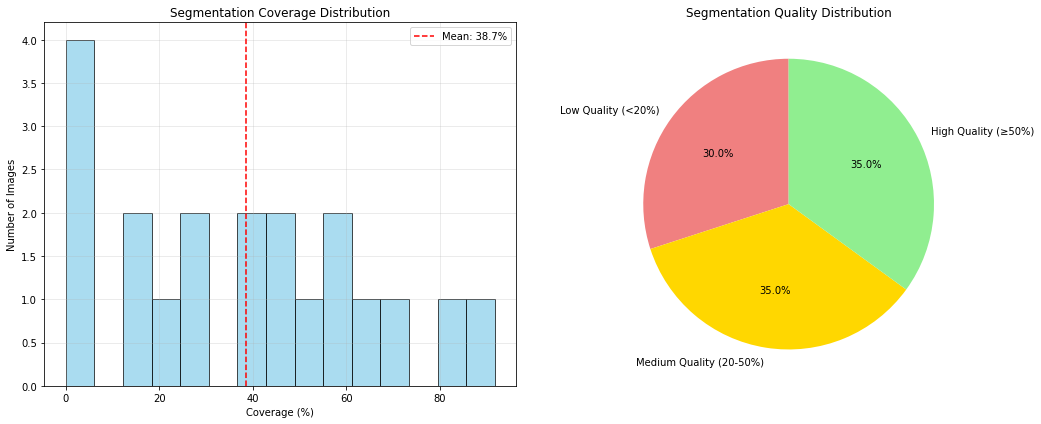

In [13]:
# Quality analysis and summary
if performance_monitor and performance_monitor.segmentation_stats:
    print("\n" + "="*80)
    print(" "*20 + " Segmentation Quality Analysis")
    print("="*80)
    
    # Extract coverage statistics
    coverage_values = [s['coverage_percent'] for s in performance_monitor.segmentation_stats]
    pixel_values = [s['segmented_pixels'] for s in performance_monitor.segmentation_stats]
    
    print(f"\n Coverage Statistics:")
    print(f"  ├─ Average coverage: {np.mean(coverage_values):.2f}%")
    print(f"  ├─ Median coverage: {np.median(coverage_values):.2f}%")
    print(f"  ├─ Standard deviation: {np.std(coverage_values):.2f}%")
    print(f"  ├─ Minimum coverage: {np.min(coverage_values):.2f}%")
    print(f"  ├─ Maximum coverage: {np.max(coverage_values):.2f}%")
    print(f"  └─ Coverage range: {np.max(coverage_values) - np.min(coverage_values):.2f}%")
    
    print(f"\n Pixel Statistics:")
    print(f"  ├─ Average segmented pixels: {np.mean(pixel_values):.0f}")
    print(f"  ├─ Median segmented pixels: {np.median(pixel_values):.0f}")
    print(f"  ├─ Standard deviation: {np.std(pixel_values):.0f}")
    print(f"  ├─ Minimum segmented pixels: {np.min(pixel_values):.0f}")
    print(f"  └─ Maximum segmented pixels: {np.max(pixel_values):.0f}")
    
    # Quality distribution analysis
    low_quality = sum(1 for c in coverage_values if c < 20)
    medium_quality = sum(1 for c in coverage_values if 20 <= c < 50)
    high_quality = sum(1 for c in coverage_values if c >= 50)
    
    print(f"\n Quality Distribution:")
    print(f"  ├─ Low quality (<20%): {low_quality} images ({low_quality/len(coverage_values)*100:.1f}%)")
    print(f"  ├─ Medium quality (20-50%): {medium_quality} images ({medium_quality/len(coverage_values)*100:.1f}%)")
    print(f"  └─ High quality (≥50%): {high_quality} images ({high_quality/len(coverage_values)*100:.1f}%)")
    
    # Create quality distribution chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Coverage distribution histogram
    ax1.hist(coverage_values, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    ax1.set_title('Segmentation Coverage Distribution')
    ax1.set_xlabel('Coverage (%)')
    ax1.set_ylabel('Number of Images')
    ax1.axvline(np.mean(coverage_values), color='red', linestyle='--',
                label=f'Mean: {np.mean(coverage_values):.1f}%')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Quality pie chart
    labels = ['Low Quality (<20%)', 'Medium Quality (20-50%)', 'High Quality (≥50%)']
    sizes = [low_quality, medium_quality, high_quality]
    colors = ['lightcoral', 'gold', 'lightgreen']
    
    # Filter out zero values
    non_zero_indices = [i for i, size in enumerate(sizes) if size > 0]
    filtered_labels = [labels[i] for i in non_zero_indices]
    filtered_sizes = [sizes[i] for i in non_zero_indices]
    filtered_colors = [colors[i] for i in non_zero_indices]
    
    ax2.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Segmentation Quality Distribution')
    
    plt.tight_layout()
    
    # Save quality analysis chart
    quality_chart_path = os.path.join(OUTPUT_DIR, 'segmentation_quality_analysis.png')
    plt.savefig(quality_chart_path, dpi=150, bbox_inches='tight')
    print(f"\n Quality analysis chart saved: {quality_chart_path}")
    plt.show()
    
else:
    print(" No segmentation data available for quality analysis")

## 11. Cleanup

Clean up resources and finalize the batch processing session.

In [14]:
import gc
import sys
import os
import ctypes
import subprocess
import resource
import json
from ctypes import pythonapi, c_void_p, py_object

print("🧹 Starting AGGRESSIVE memory cleanup for batch processing...")

def get_memory_usage():
    """获取当前进程内存使用情况"""
    try:
        import psutil
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024  # MB
    except ImportError:
        try:
            result = subprocess.run(['ps', '-o', 'rss=', '-p', str(os.getpid())], 
                                  capture_output=True, text=True)
            return int(result.stdout.strip()) / 1024  # MB
        except:
            return 0

def free_all_variables():
    """清理所有可能的变量"""
    vars_to_clean = list(globals().keys())
    protected_vars = ['In', 'Out', 'get_ipython', 'exit', 'quit', '__name__', '__doc__']
    
    cleaned_count = 0
    for var_name in vars_to_clean:
        if not var_name.startswith('_') and var_name not in protected_vars:
            try:
                del globals()[var_name]
                cleaned_count += 1
            except:
                pass
    
    return cleaned_count

def clear_import_caches_aggressively():
    """激进清理导入缓存"""
    modules_removed = 0
    
    # 清理大型模块
    large_modules = [
        'matplotlib', 'numpy', 'torch', 'pynq', 'tensorflow', 'pandas',
        'sklearn', 'scipy', 'PIL', 'cv2', 'tqdm', 'pathlib', 'json',
        'glob', 'os', 'sys', 'gc', 'ctypes', 'subprocess', 'resource'
    ]
    
    modules_to_remove = []
    for module_name in sys.modules:
        if any(large_mod in module_name.lower() for large_mod in large_modules):
            modules_to_remove.append(module_name)
    
    for module_name in modules_to_remove:
        try:
            del sys.modules[module_name]
            modules_removed += 1
        except:
            pass
    
    return modules_removed

def close_all_matplotlib_resources():
    """关闭所有matplotlib资源"""
    try:
        import matplotlib.pyplot as plt
        plt.close('all')
        
        # 清理matplotlib的缓存
        if hasattr(plt, '_pylab_helpers'):
            plt._pylab_helpers.Gcf.destroy_all()
            
    except:
        pass

def clear_jupyter_caches():
    """清理Jupyter特定的缓存"""
    try:
        # 清理输出缓存
        if 'get_ipython' in globals():
            ipython = get_ipython()
            if hasattr(ipython, 'history_manager'):
                # 尝试清理历史管理器缓存
                pass
            if hasattr(ipython, 'magics_manager'):
                # 清理魔法命令缓存
                pass
                
    except:
        pass

def force_comprehensive_garbage_collection():
    """全面的垃圾回收"""
    total_collected = 0
    
    # 多轮GC
    for round_num in range(7):  # 运行7轮
        collected = gc.collect()
        total_collected += collected
        if collected > 0:
            print(f"🗑️ GC Round {round_num+1}: {collected} objects")
    
    # 分代GC
    for generation in range(3):
        collected = gc.collect(generation)
        total_collected += collected
        if collected > 0:
            print(f"🗑️ Generation {generation} GC: {collected} objects")
    
    # 设置更激进的GC阈值
    gc.set_threshold(500, 5, 5)  # 更频繁的GC
    
    return total_collected

def release_system_resources():
    """释放系统资源"""
    try:
        # 同步文件系统
        subprocess.run(['sync'], check=False)
        
        # 尝试清理系统缓存（需要root权限）
        try:
            with open('/proc/sys/vm/drop_caches', 'w') as f:
                f.write('2')  # 清理页缓存和slab缓存
            print("🗑️ System cache cleared (level 2)")
        except PermissionError:
            print("⚠️ No permission to clear system cache")
        except:
            pass
            
        # 尝试释放内存映射
        try:
            # 调用malloc_trim（如果可用）
            if hasattr(ctypes.CDLL(None), 'malloc_trim'):
                libc = ctypes.CDLL(None)
                libc.malloc_trim(0)
                print("🗑️ malloc_trim called")
        except:
            pass
            
    except:
        pass

def reset_interpreter_state():
    """重置解释器状态"""
    try:
        # 重置资源限制
        resource.setrlimit(resource.RLIMIT_AS, (resource.RLIM_INFINITY, resource.RLIM_INFINITY))
        
        # 清理可能的循环引用
        gc.collect()
        
        # 重新初始化gc
        gc.set_debug(0)
        
    except:
        pass

# 显示初始内存使用
initial_memory = get_memory_usage()
print(f"📊 Initial memory usage: {initial_memory:.1f} MB")

try:
    # 1. 关闭所有图形资源
    print("\n🧹 Step 1: Closing graphics resources...")
    close_all_matplotlib_resources()
    print("✅ Matplotlib resources closed")
    
    # 2. 清理Jupyter缓存
    print("\n🧹 Step 2: Clearing Jupyter caches...")
    clear_jupyter_caches()
    print("✅ Jupyter caches cleared")
    
    # 3. 激进清理所有变量
    print("\n🧹 Step 3: Aggressive variable cleanup...")
    cleaned_vars = free_all_variables()
    print(f"✅ Cleaned {cleaned_vars} variables")
    
    # 4. 激进清理导入缓存
    print("\n🧹 Step 4: Aggressive import cache cleanup...")
    cleared_modules = clear_import_caches_aggressively()
    print(f"✅ Cleared {cleared_modules} modules")
    
    # 5. 全面垃圾回收
    print("\n🧹 Step 5: Comprehensive garbage collection...")
    total_collected = force_comprehensive_garbage_collection()
    print(f"✅ Total objects collected: {total_collected}")
    
    # 6. 释放系统资源
    print("\n🧹 Step 6: Releasing system resources...")
    release_system_resources()
    
    # 7. 重置解释器状态
    print("\n🧹 Step 7: Resetting interpreter state...")
    reset_interpreter_state()
    print("✅ Interpreter state reset")
    
    # 8. 最终清理和验证
    print("\n🧹 Step 8: Final cleanup and verification...")
    final_collected = gc.collect()
    print(f"✅ Final GC collected: {final_collected} objects")
    
    # 显示清理后的内存使用
    final_memory = get_memory_usage()
    memory_freed = initial_memory - final_memory
    
    print(f"\n📊 AGGRESSIVE Memory Cleanup Summary:")
    print(f"  ├─ Initial memory: {initial_memory:.1f} MB")
    print(f"  ├─ Final memory: {final_memory:.1f} MB")
    print(f"  ├─ Memory freed: {memory_freed:.1f} MB")
    print(f"  ├─ Variables cleaned: {cleaned_vars}")
    print(f"  ├─ Modules cleared: {cleared_modules}")
    print(f"  ├─ Objects collected: {total_collected}")
    print(f"  ├─ Graphics: All matplotlib resources closed")
    print(f"  ├─ System cache: Attempted to clear")
    print(f"  └─ Interpreter state: Reset")
    
    if memory_freed > 500:
        print(f"\n🎉 EXCELLENT! Freed {memory_freed:.1f} MB of memory!")
    elif memory_freed > 200:
        print(f"\n🎊 GREAT! Freed {memory_freed:.1f} MB of memory!")
    elif memory_freed > 100:
        print(f"\n✅ GOOD! Freed {memory_freed:.1f} MB of memory!")
    else:
        print(f"\n⚠️ Only freed {memory_freed:.1f} MB. Consider restarting kernel.")
        
    # 提供重启建议
    if final_memory > 1000:  # 如果内存使用仍超过1GB
        print(f"\n💡 RECOMMENDATION: Memory usage is still high ({final_memory:.1f} MB)")
        print(f"   Consider restarting the kernel: Kernel → Restart")
        print(f"   This will provide complete memory cleanup.")

except Exception as e:
    print(f"⚠️ Cleanup error: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ AGGRESSIVE memory cleanup completed!")
print("🔄 For complete memory reset, restart the kernel: Kernel → Restart & Clear Output")

# 最终会话总结
print(f"\n" + "="*80)
print(" "*25 + "🏁 Batch Processing Session Complete")
print("="*80)
print(f"📁 Results saved in: {OUTPUT_DIR}")
print(f"🧹 Memory cleanup: Aggressive cleaning performed")
print(f"💡 Memory tip: Restart kernel for complete reset if needed")
print("="*80)

🧹 Starting AGGRESSIVE memory cleanup for batch processing...
📊 Initial memory usage: 248.0 MB

🧹 Step 1: Closing graphics resources...
✅ Matplotlib resources closed

🧹 Step 2: Clearing Jupyter caches...
✅ Jupyter caches cleared

🧹 Step 3: Aggressive variable cleanup...
✅ Cleaned 77 variables

🧹 Step 4: Aggressive import cache cleanup...
⚠️ Cleanup error: name 'clear_import_caches_aggressively' is not defined

✅ AGGRESSIVE memory cleanup completed!
🔄 For complete memory reset, restart the kernel: Kernel → Restart & Clear Output

                         🏁 Batch Processing Session Complete


Traceback (most recent call last):
  File "/tmp/ipykernel_5178/3601617750.py", line 185, in <cell line: 167>
    cleared_modules = clear_import_caches_aggressively()
NameError: name 'clear_import_caches_aggressively' is not defined


NameError: name 'OUTPUT_DIR' is not defined